<img src='https://i.imgur.com/Rk5wkBQ.png'>

<img src='https://vinija.ai/models/assets/transformers/5.png'>


Ï∂úÏ≤ò : https://vinija.ai/models/Transformers/

## TransformerÏùò Í∏∞Î≥∏ Í∞úÎÖêÏùÑ ÏΩîÎìúÎ•º ÌÜµÌï¥ Ïù¥Ìï¥Ìï¥Î≥¥Ïûê!

- Step 0 : Ï§ÄÎπÑÌïòÍ∏∞

In [ ]:
import tensorflow as tf
import numpy as np
import math

- step 1 : Postional Encoding

In [ ]:
#ÏúÑÏπò Ïù∏ÏΩîÎî© Ìï®Ïàò Ï†ïÏùò
def get_angles(pos,i,d_model):
    #ÏúÑÏπòÎ≥ÑÎ°ú Ï£ºÍ∏∞Î•º Îã§Î•¥Í≤å Ìï¥ÏÑú Í≥†Ïú†Ìïú Í∞íÏùÑ ÏÉùÏÑ±.
    angle_rates = 1 / np.power(10000, ((2*i//2)) / np.float32(d_model))
    return pos*angle_rates
# pos : ÏúÑÏπò Ï†ïÎ≥¥(1,2,...max_position), i : ÏûÑÎ≤†Îî© Î≤°ÌÑ∞Ïùò Í∞Å Ï∞®Ïõê Ïù∏Îç±Ïä§(0,1,2, ...d_model-1)
# angle_rates : ÏúÑÏπòÎ≥ÑÎ°ú Í∞Å Ï∞®ÏõêÎßàÎã§ Ï£ºÍ∏∞Ï†ÅÏù∏ Í∞íÏùÑ ÏÉùÏÑ±ÌïòÎäî ÎπÑÏú®
# -> Î™®Îì† Îã®Ïñ¥ ÏúÑÏπò(pos)ÏôÄ Î™®Îì† ÏûÑÎ≤†Îî© Ï∞®Ïõê(i) ÏåçÏóê ÎåÄÌï¥, ÏúÑÏπò Í∞ÅÎèÑÎ•º Í≥ÑÏÇ∞ÌïúÎã§.
def positional_encoding(position, d_model):
    #position : ÏµúÎåÄ Î¨∏Ïû• Í∏∏Ïù¥ / d_model : ÏûÑÎ≤†Îî© Ï∞®Ïõê Ïàò
    angle_rads = get_angles(np.arange(position)[:,np.newaxis], #Í∞Å Îã®Ïñ¥Ïùò ÏúÑÏπò
                            np.arange(d_model)[np.newaxis,:], #Í∞Å ÏûÑÎ≤†Îî© Ï∞®ÏõêÏùÑ Î≤°ÌÑ∞Î°ú ÌëúÌòÑ
                            d_model) #(position, d_model) -> shapeÏù¥ ÌôïÏû•.
    #ÏßùÏàò Ïù∏Îç±Ïä§ÏóêÎäî sin, ÌôÄÏàò Ïù∏Îç±Ïä§Îäî cos Ìï®Ïàò Ï†ÅÏö©.
    angle_rads[:,0::2] = np.sin(angle_rads[:,0::2]) #even
    angle_rads[:,1::2] = np.cos(angle_rads[:,1::2]) #odd

    pos_encoding = angle_rads[np.newaxis,...] #(1,postion, d_model)
    #Ï∞®ÏõêÏùÑ ÎäòÎ¶¨Îäî Ïù¥Ïú† : TransformerÏóêÏÑúÎäî batchÎã®ÏúÑÎ°ú ÌïôÏäµÏùÑ ÏßÑÌñâÌïòÍ∏∞ ÎïåÎ¨∏Ïóê
    # shapeÏù¥ (1,postion, d_model)Ïù¥ ÎêòÏñ¥ÏïºÌï®.
    return tf.cast(pos_encoding, dtype=tf.float32)

np.arange(position)[:,newaxis]

In [ ]:
#ex) position=4
np.arange(4)[:,np.newaxis]

array([[0],
       [1],
       [2],
       [3]])

In [ ]:
np.arange(4)[np.newaxis,:]

array([[0, 1, 2, 3]])

2. Scale Dot-Product Attention

In [ ]:
def scaled_dot_product_attention(Q,K,V,mask=None):
    # Q: Query(batch, num_heads, seq_len_q,depth)
    # K: Key(batch, num_heads, seq_len_k,depth)
    # V: Value(batch, num_heads, seq_len_v,depth_v)
    # Ïù¥ Ìï®ÏàòÎäî Query(Q), Key(K),Value(V)Î•º Î∞õÏïÑÏÑú Ïñ¥Îñ§ Îã®Ïñ¥Í∞Ä ÏñºÎßàÎÇò ÏßëÏ§ë(attend)Ìï¥Ïïº ÌïòÎäîÏßÄ Í≥ÑÏÇ∞.
    matmul_qk = tf.matmul(Q,K,transpose_b=True) #QÏôÄ KÏùò ÎÇ¥Ï†Å(Ïú†ÏÇ¨ÎèÑ Í≥ÑÏÇ∞)
    # Q(Query)Îäî Ïñ¥Îñ§ Îã®Ïñ¥Í∞Ä ÏßàÎ¨∏ÏùÑ ÎçòÏßê.
    # K(Key)Îäî Î™®Îì† Îã®Ïñ¥Îì§Ïù¥ ÎåÄÎãµ ÌõÑÎ≥¥Í∞Ä Îê®.
    # QÏôÄ KÏùò ÎÇ¥Ï†Å => Îã®Ïñ¥ Í∞Ñ Ïú†ÏÇ¨ÎèÑ(ÏπúÎ∞ÄÎèÑ, Ï§ëÏöîÎèÑ)
    # matmul_qk.shape => (batch, heads, seq_len_q, seq_len_k) => Í∞Å query Îã®Ïñ¥Í∞Ä Î™®Îì† KeyÏóê ÏñºÎßàÎÇò Ï£ºÎ™©ÌïòÎäîÏßÄ


    #Ï∞®Ïõê ÏàòÎ•º Î£®Ìä∏Î°ú ÎÇòÎàÑÏñ¥ Ï†ïÍ∑úÌôî(ÏïàÏ†ïÏÑ±)
    # dot productÎäî depth Ï∞®Ïõê ÏàòÍ∞Ä ÌÅ¥ÏàòÎ°ù, Í∞íÏù¥ Ïª§Ïßà Í∞ÄÎä•ÏÑ±Ïù¥ ÏûàÍ∏∞ ÎïåÎ¨∏Ïóê Ï†ïÍ∑úÌôîÎ•º ÏßÑÌñâÌï®.
    dk = tf.cast(tf.shape(K)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    #ÎßàÏä§ÌÇπ Ï†ÅÏö©(ex) decoderÏóêÏÑú future Îã®Ïñ¥ Í∞ÄÎ¶º.(masking future words)
    # ex) I am fine -> <sos>(ÏãúÏûë ÌÜ†ÌÅ∞ Ï£ºÍ≥†) -> I ÏòàÏ∏°
    # IÏ£ºÍ≥† am ÏòàÏ∏° / am Ï£ºÍ≥† fine ÏòàÏ∏° / decoderÎäî Ìïú Í∏ÄÏûêÏî© ÏòàÏ∏°ÏùÑ Ìï®.
    # TransformerÎäî DecoderÏóêÏÑú self-attentionÏùÑ ÏßÑÌñâÌï† Îïå Look-ahead Masking(ÎØ∏Îûò Îã®Ïñ¥ Í∞ÄÎ¶¨Í∏∞)Î•º Ìï®.
    if mask is not None:
        scaled_attention_logits += (mask * -1e-9 ) #Îß§Ïö∞ ÏûëÏùÄ Í∞íÏúºÎ°ú Í∞ÄÎ†§ softmaxÏóêÏÑú 0Ïù¥ ÎêòÍ≤åÌï®.

    # ÏÜåÌîÑÌä∏Îß•Ïä§Î°ú Í∞ÄÏ§ëÏπò Í≥ÑÏÇ∞
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    # Í∞ÄÏ§ëÏπòÎ•º VÎ•º Í≥±Ìï¥ÏÑú ÏµúÏ¢Ö Ï∂úÎ†•
    output = tf.matmul(attention_weights, V)

    return output, attention_weights


3. Multi-Head Attention Layer

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0 #Î®∏Î¶¨ ÏàòÎäî d_modelÎ°ú ÎÇòÎàÑÏñ¥ Îñ®Ïñ¥Ï†∏Ïïº Ìï®.

        self.num_heads = num_heads
        self.depth = d_model // num_heads

        # Query, Key, ValueÎ•º ÏúÑÌïú Dense layer(ÏÑ†Ìòï Î≥ÄÌôòÏö©)
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self,x,batch_size):
        # x : (batch_size, seq_len, d_model)
        # =>  (batch_size, num_heads,seq_len, depth)
        # ÌïòÎÇòÏùò AttentionÏùÑ ÌïòÎäîÍ≤å ÏïÑÎãàÎùº, Ïó¨Îü¨ Í∞úÏùò "ÏãúÏÑ†ÏùÑ ÎÇòÎà†ÏÑú ÎèôÏãúÏóê" AttentionÏùÑ ÏàòÌñâ;.

        x = tf.reshape(x,(batch_size, -1, self.num_heads, self.depth))
        # ex) d_model = 512, num_heads=8 -> depth=64
        # x.shape => (32,20,512) -> 32Í∞úÏùò Î¨∏Ïû•(batch), Í∞Å Î¨∏Ïû• 20Îã®Ïñ¥, 512Ï∞®Ïõê ÏûÑÎ≤†Îî©
        # -> headÍ∞Ä Îí§Ïóê ÏúÑÏπòÌïòÍ≤å Îê®. (batch, seq_len, num_heads, depth)
        return tf.transpose(x, perm=[0,2,1,3])
        # (batch_size, num_heads, seq_len,depth) -> Ïù¥ Íµ¨Ï°∞Í∞Ä ÏûàÏñ¥Ïïº Í∞Å headÎ≥ÑÎ°ú attetnion Ïó∞ÏÇ∞ÏùÑ ÏâΩÍ≤å Ìï† Ïàò ÏûàÎã§.

    def call(self,v,k,q, mask=None):
        batch_size = tf.shape(q)[0]

        #Q,K,V ÏÉùÏÑ±
        Q = self.W_q(q) #(batch_size, seq_len_q,d_model)
        K = self.W_k(k) #(batch_size, seq_len_k,d_model)
        V = self.W_v(v) #(batch_size, seq_len_v,d_model)

        # Q,K,V ÏÉùÏÑ± ÌõÑ headsÎ°ú ÎÇòÎàÑÍ∏∞
        Q = self.split_heads(Q,batch_size)
        K = self.split_heads(K,batch_size)
        V = self.split_heads(V,batch_size)

        #scaled Dot Product Attention Ï†ÅÏö©
        scaled_attention, attention_weights  = scaled_dot_product_attention(Q,K,V,mask)

        #headÎì§ÏùÑ Îã§Ïãú concat(transpose block ->reshape)
        scaled_attention = tf.transpose(scaled_attention,perm=[0,2,1,3]) #(batch, seq_len,heads,depth)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.num_heads *self.depth))

        #ÏµúÏ¢Ö Ï∂úÎ†•
        output = self.dense(concat_attention)
        return output, attention_weights
        #attention_weights : Ïñ¥Îñ§ Îã®Ïñ¥Ïóê ÏßëÏ§ëÎÇ¥Îäî Í∞í.

4. Transformer Block(EncoderÏóêÏÑú ÏÇ¨Ïö©)

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff,activation='relu'), #ÌôïÏû•
        tf.keras.layers.Dense(d_model)
    ])

In [ ]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self,d_model, num_heads, dff, rate=0.1):
        super().__init__()

        self.mha= MultiHeadAttention(d_model, num_heads) #Multi-head Attention
        self.ffn = point_wise_feed_forward_network(d_model,dff) #Feed-forword network

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    def call(self,x,training,mask=None):
        #1.self-attention ÏàòÌñâ
        attn_output, attn_weights = self.mha(x,x,x,mask) #(batch, seq_len,d_model)
        attn_output = self.dropout1(attn_output, training = training)
        out1 = self.layernorm1(x+attn_output) #ÏûîÏ∞® Ïó∞Í≤∞+ Ï†ïÍ∑úÌôî

        #2. Feed-forward Network ÏàòÌñâ
        ffn_output = self.ffn(out1) # (batch, seq_len,d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1+ffn_output)
        return out2,attn_weights

ÏãúÍ∞ÅÌôî Ìï®Ïàò ÎßåÎì§Í∏∞(HeadÎ≥Ñ Attention Map)

In [ ]:
sample_input = tf.random.uniform((1, 10, 512))
mha = MultiHeadAttention(d_model=512, num_heads=8)
output, attention_weights = mha(sample_input, sample_input, sample_input)

print(output.shape)        # (1, 10, 512)
print(attention_weights.shape)  # (1, 8, 10, 10)

(1, 10, 512)
(1, 8, 10, 10)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_attention_map(attn_weights, head=0):
    # atten_weights : (bacth,heads, seq_len, seq_len)
    # head : Î≥¥Í≥† Ïã∂ÏùÄ attention head index
    atten = attn_weights[0][head]
    plt.figure(figsize=(6,5))
    plt.title(f'Attention Map - Head {head}')
    plt.imshow(atten, cmap='viridis')
    plt.xlabel('Key ÏúÑÏπò')
    plt.ylabel('Query ÏúÑÏπò')
    plt.colorbar()
    plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


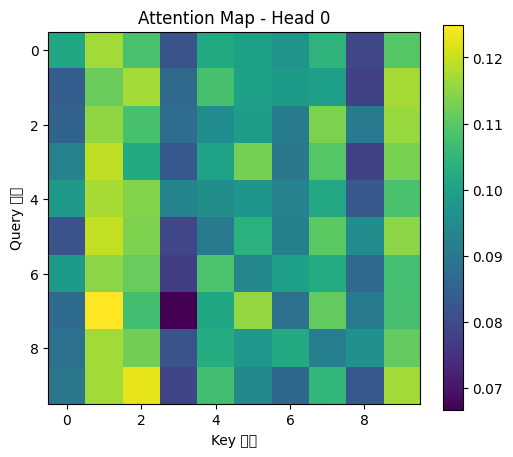

In [ ]:
show_attention_map(attention_weights.numpy(), head=0)

Ïó¨Îü¨ head Ìï®Ïàò Î≥¥Í∏∞

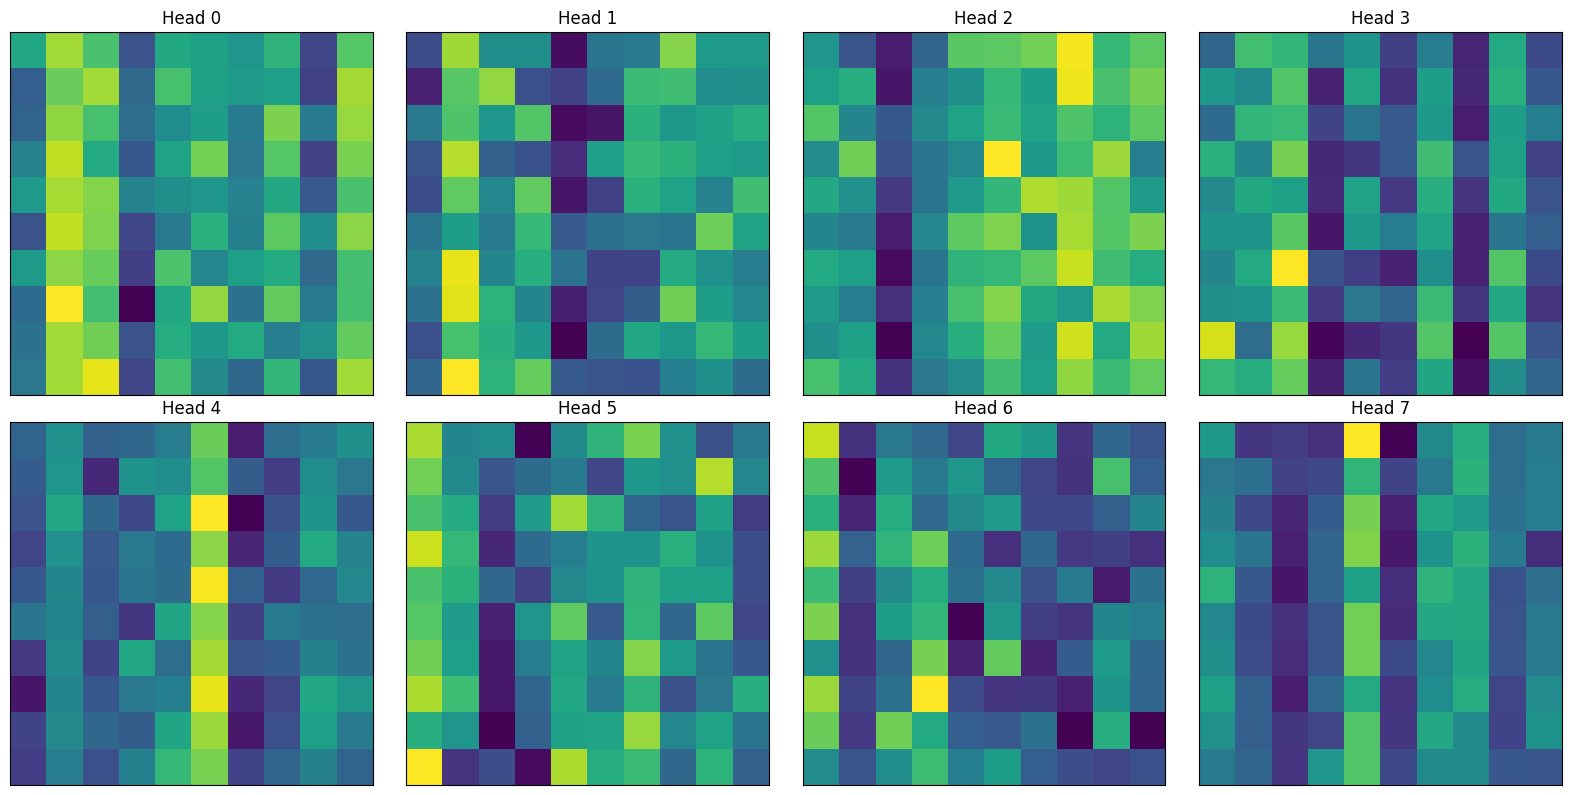

In [ ]:
def show_all_heads(attn_weights):
    num_heads = attn_weights.shape[1]
    plt.figure(figsize=(16, 8))
    for i in range(num_heads):
        plt.subplot(2, num_heads//2, i+1)
        plt.imshow(attn_weights[0][i], cmap='viridis')
        plt.title(f"Head {i}")
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

# Ïã§Ìñâ
show_all_heads(attention_weights.numpy())

### Ïã§Ï†ú Î¨∏Ïû• ÎÑ£Îäî Ï†ÑÏ≤¥ Íµ¨Ï°∞

Tokenizer -> ÏûÑÎ≤†Îî©+ÏúÑÏπò ÏûÑÎ≤†Îî© ->TransfomerBlock->Attenion ÏãúÍ∞ÅÌôî

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

#1. ÏòàÏ†ú Î¨∏Ïû•
sentences = [
    'I love machine learning',
    'transfomers are powerful'
]

#2.TokenizerÎ°ú Ï†ïÏàò ÏãúÌÄÄÏä§ Î≥ÄÌôò.
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<unk>')
#OOV : out of vocabulary, Îì±Ïû•ÌïòÏßÄ ÏïäÏïòÎçò Îã®Ïñ¥Îì§ÏùÄ Unknown ÏúºÎ°ú Ï≤òÎ¶¨
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
padded_seq = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding='post')
print('Ï†ïÏàò ÏãúÌÄÄÏä§', padded_seq)

#3.ÌååÎùºÎØ∏ÌÑ∞ ÏÑ§Ï†ï.
vocab_size = len(tokenizer.word_index)+1
d_model = 64
max_len = padded_seq.shape[1]

#ÏúÑÏπò Ïù∏ÏΩîÎî© Ìï®Ïàò Ï†ïÏùò
def get_angles(pos,i,d_model):
    angle_rates = 1 / np.power(10000, ((2*i//2)) / np.float32(d_model))
    return pos*angle_rates

def positional_encoding(position, d_model):

    angle_rads = get_angles(np.arange(position)[:,np.newaxis],
                            np.arange(d_model)[np.newaxis,:],
                            d_model)
    angle_rads[:,0::2] = np.sin(angle_rads[:,0::2])
    angle_rads[:,1::2] = np.cos(angle_rads[:,1::2])

    pos_encoding = angle_rads[np.newaxis,...]
    return tf.cast(pos_encoding, dtype=tf.float32)

# 5. ÏûÑÎ≤†Îî©+ÏúÑÏπò Ïù∏ÏΩîÎî©
embedding = tf.keras.layers.Embedding(vocab_size,d_model)
x = embedding(padded_seq)
x += positional_encoding(max_len, d_model)
print('ÏûÑÎ≤†Îî©+ÏúÑÏπò Ïù∏ÏΩîÎî© shape', x.shape)

Ï†ïÏàò ÏãúÌÄÄÏä§ [[2 3 4 5]
 [6 7 8 0]]
ÏûÑÎ≤†Îî©+ÏúÑÏπò Ïù∏ÏΩîÎî© shape (2, 4, 64)


In [ ]:
def scaled_dot_product_attention(Q,K,V,mask=None):
    # Q: Query(batch, num_heads, seq_len_q,depth)
    # K: Key(batch, num_heads, seq_len_k,depth)
    # V: Value(batch, num_heads, seq_len_v,depth_v)
    # Ïù¥ Ìï®ÏàòÎäî Query(Q), Key(K),Value(V)Î•º Î∞õÏïÑÏÑú Ïñ¥Îñ§ Îã®Ïñ¥Í∞Ä ÏñºÎßàÎÇò ÏßëÏ§ë(attend)Ìï¥Ïïº ÌïòÎäîÏßÄ Í≥ÑÏÇ∞.
    matmul_qk = tf.matmul(Q,K,transpose_b=True) #QÏôÄ KÏùò ÎÇ¥Ï†Å(Ïú†ÏÇ¨ÎèÑ Í≥ÑÏÇ∞)
    # Q(Query)Îäî Ïñ¥Îñ§ Îã®Ïñ¥Í∞Ä ÏßàÎ¨∏ÏùÑ ÎçòÏßê.
    # K(Key)Îäî Î™®Îì† Îã®Ïñ¥Îì§Ïù¥ ÎåÄÎãµ ÌõÑÎ≥¥Í∞Ä Îê®.
    # QÏôÄ KÏùò ÎÇ¥Ï†Å => Îã®Ïñ¥ Í∞Ñ Ïú†ÏÇ¨ÎèÑ(ÏπúÎ∞ÄÎèÑ, Ï§ëÏöîÎèÑ)
    # matmul_qk.shape => (batch, heads, seq_len_q, seq_len_k) => Í∞Å query Îã®Ïñ¥Í∞Ä Î™®Îì† KeyÏóê ÏñºÎßàÎÇò Ï£ºÎ™©ÌïòÎäîÏßÄ


    #Ï∞®Ïõê ÏàòÎ•º Î£®Ìä∏Î°ú ÎÇòÎàÑÏñ¥ Ï†ïÍ∑úÌôî(ÏïàÏ†ïÏÑ±)
    # dot productÎäî depth Ï∞®Ïõê ÏàòÍ∞Ä ÌÅ¥ÏàòÎ°ù, Í∞íÏù¥ Ïª§Ïßà Í∞ÄÎä•ÏÑ±Ïù¥ ÏûàÍ∏∞ ÎïåÎ¨∏Ïóê Ï†ïÍ∑úÌôîÎ•º ÏßÑÌñâÌï®.
    dk = tf.cast(tf.shape(K)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    #ÎßàÏä§ÌÇπ Ï†ÅÏö©(ex) decoderÏóêÏÑú future Îã®Ïñ¥ Í∞ÄÎ¶º.(masking future words)
    # ex) I am fine -> <sos>(ÏãúÏûë ÌÜ†ÌÅ∞ Ï£ºÍ≥†) -> I ÏòàÏ∏°
    # IÏ£ºÍ≥† am ÏòàÏ∏° / am Ï£ºÍ≥† fine ÏòàÏ∏° / decoderÎäî Ìïú Í∏ÄÏûêÏî© ÏòàÏ∏°ÏùÑ Ìï®.
    # TransformerÎäî DecoderÏóêÏÑú self-attentionÏùÑ ÏßÑÌñâÌï† Îïå Look-ahead Masking(ÎØ∏Îûò Îã®Ïñ¥ Í∞ÄÎ¶¨Í∏∞)Î•º Ìï®.
    if mask is not None:
        scaled_attention_logits += (mask * -1e-9 ) #Îß§Ïö∞ ÏûëÏùÄ Í∞íÏúºÎ°ú Í∞ÄÎ†§ softmaxÏóêÏÑú 0Ïù¥ ÎêòÍ≤åÌï®.

    # ÏÜåÌîÑÌä∏Îß•Ïä§Î°ú Í∞ÄÏ§ëÏπò Í≥ÑÏÇ∞
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    # Í∞ÄÏ§ëÏπòÎ•º VÎ•º Í≥±Ìï¥ÏÑú ÏµúÏ¢Ö Ï∂úÎ†•
    output = tf.matmul(attention_weights, V)

    return output, attention_weights


In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0 #Î®∏Î¶¨ ÏàòÎäî d_modelÎ°ú ÎÇòÎàÑÏñ¥ Îñ®Ïñ¥Ï†∏Ïïº Ìï®.

        self.num_heads = num_heads
        self.depth = d_model // num_heads

        # Query, Key, ValueÎ•º ÏúÑÌïú Dense layer(ÏÑ†Ìòï Î≥ÄÌôòÏö©)
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self,x,batch_size):
        # x : (batch_size, seq_len, d_model)
        # =>  (batch_size, num_heads,seq_len, depth)
        # ÌïòÎÇòÏùò AttentionÏùÑ ÌïòÎäîÍ≤å ÏïÑÎãàÎùº, Ïó¨Îü¨ Í∞úÏùò "ÏãúÏÑ†ÏùÑ ÎÇòÎà†ÏÑú ÎèôÏãúÏóê" AttentionÏùÑ ÏàòÌñâ;.

        x = tf.reshape(x,(batch_size, -1, self.num_heads, self.depth))
        # ex) d_model = 512, num_heads=8 -> depth=64
        # x.shape => (32,20,512) -> 32Í∞úÏùò Î¨∏Ïû•(batch), Í∞Å Î¨∏Ïû• 20Îã®Ïñ¥, 512Ï∞®Ïõê ÏûÑÎ≤†Îî©
        # -> headÍ∞Ä Îí§Ïóê ÏúÑÏπòÌïòÍ≤å Îê®. (batch, seq_len, num_heads, depth)
        return tf.transpose(x, perm=[0,2,1,3])
        # (batch_size, num_heads, seq_len,depth) -> Ïù¥ Íµ¨Ï°∞Í∞Ä ÏûàÏñ¥Ïïº Í∞Å headÎ≥ÑÎ°ú attetnion Ïó∞ÏÇ∞ÏùÑ ÏâΩÍ≤å Ìï† Ïàò ÏûàÎã§.

    def call(self,v,k,q, mask=None):
        batch_size = tf.shape(q)[0]

        #Q,K,V ÏÉùÏÑ±
        Q = self.W_q(q) #(batch_size, seq_len_q,d_model)
        K = self.W_k(k) #(batch_size, seq_len_k,d_model)
        V = self.W_v(v) #(batch_size, seq_len_v,d_model)

        # Q,K,V ÏÉùÏÑ± ÌõÑ headsÎ°ú ÎÇòÎàÑÍ∏∞
        Q = self.split_heads(Q,batch_size)
        K = self.split_heads(K,batch_size)
        V = self.split_heads(V,batch_size)

        #scaled Dot Product Attention Ï†ÅÏö©
        scaled_attention, attention_weights  = scaled_dot_product_attention(Q,K,V,mask)

        #headÎì§ÏùÑ Îã§Ïãú concat(transpose block ->reshape)
        scaled_attention = tf.transpose(scaled_attention,perm=[0,2,1,3]) #(batch, seq_len,heads,depth)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.num_heads *self.depth))

        #ÏµúÏ¢Ö Ï∂úÎ†•
        output = self.dense(concat_attention)
        return output, attention_weights
        #attention_weights : Ïñ¥Îñ§ Îã®Ïñ¥Ïóê ÏßëÏ§ëÎÇ¥Îäî Í∞í.

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff,activation='relu'), #ÌôïÏû•
        tf.keras.layers.Dense(d_model)
    ])

In [ ]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self,d_model, num_heads, dff, rate=0.1):
        super().__init__()

        self.mha= MultiHeadAttention(d_model, num_heads) #Multi-head Attention
        self.ffn = point_wise_feed_forward_network(d_model,dff) #Feed-forword network

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    def call(self,x,training,mask=None):
        #1.self-attention ÏàòÌñâ
        attn_output, attn_weights = self.mha(x,x,x,mask) #(batch, seq_len,d_model)
        attn_output = self.dropout1(attn_output, training = training)
        out1 = self.layernorm1(x+attn_output) #ÏûîÏ∞® Ïó∞Í≤∞+ Ï†ïÍ∑úÌôî

        #2. Feed-forward Network ÏàòÌñâ
        ffn_output = self.ffn(out1) # (batch, seq_len,d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1+ffn_output)
        return out2,attn_weights

In [ ]:
#Ïã§Ìñâ
transformer_block = TransformerBlock(d_model=64, num_heads=4, dff=128)
output, attention_weights = transformer_block(x,training=False)
print('transformer Output shape : ', output.shape)
print('Attention Weights shape : ', attention_weights.shape)

transformer Output shape :  (2, 4, 64)
Attention Weights shape :  (2, 4, 4, 4)


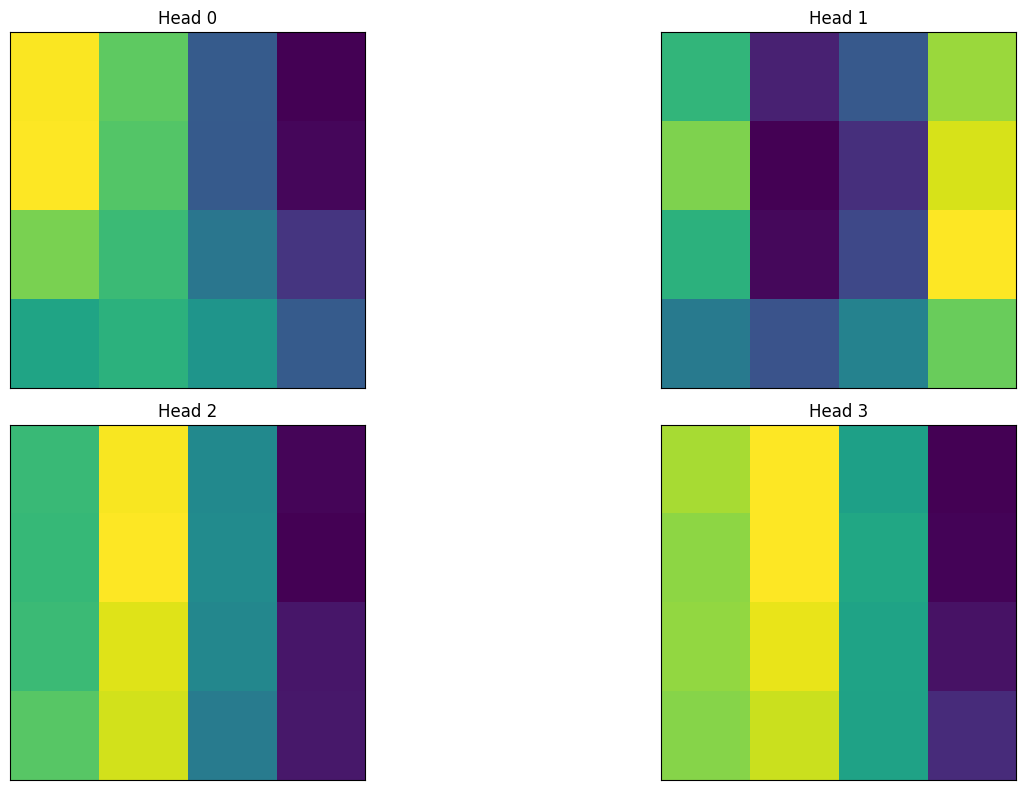

In [ ]:
def show_all_heads(attn_weights):
    num_heads = attn_weights.shape[1]
    plt.figure(figsize=(16, 8))
    for i in range(num_heads):
        plt.subplot(2, num_heads//2, i+1)
        plt.imshow(attn_weights[0][i], cmap='viridis')
        plt.title(f"Head {i}")
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

# Ïã§Ìñâ
show_all_heads(attention_weights.numpy())

# Î≥µÏäµ

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
tf.__version__

'2.18.0'

### Ìè¨ÏßÄÏÖîÎÑê Ïù∏ÏΩîÎî©

:$$ P E_{(pos,2i)} = sin(pos/10000^{2i/d_{model}}) $$
$$ P E_{(pos,2i+1)} = cos(pos/10000^{2i/d_{model}}) $$

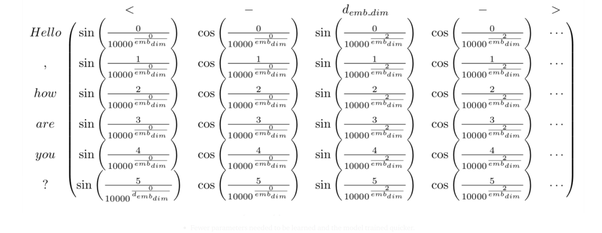

In [ ]:
import numpy as np
import tensorflow as tf

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        # ÏúÑÏπò Ïù∏ÏΩîÎî© ÌÖåÏù¥Î∏îÏùÑ ÎØ∏Î¶¨ Í≥ÑÏÇ∞ÌïòÏó¨ Ï†ÄÏû•
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        # Í∞Å ÏúÑÏπòÏôÄ Ï∞®ÏõêÏóê ÎåÄÌïú angle Í∞íÏùÑ Í≥ÑÏÇ∞
        angles = 1 / tf.pow(10000.0, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles  # broadcasting: (position, 1) * (1, d_model)

    def positional_encoding(self, position, d_model):
        # ÏúÑÏπòÏôÄ Ï∞®Ïõê Ïù∏Îç±Ïä§Î•º ÏÉùÏÑ±
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],  # (position, 1)
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],          # (1, d_model)
            d_model=d_model
        )

        # ÏßùÏàò Ïù∏Îç±Ïä§Ïóê sin, ÌôÄÏàò Ïù∏Îç±Ïä§Ïóê cos Ï†ÅÏö©
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # ÏÇ¨Ïù∏Í≥º ÏΩîÏÇ¨Ïù∏ÏùÑ ÌïòÎÇòÏùò ÌñâÎ†¨Î°ú Ìï©ÏπòÍ∏∞
        pos_encoding = np.zeros(angle_rads.shape)
        pos_encoding[:, 0::2] = sines.numpy()
        pos_encoding[:, 1::2] = cosines.numpy()

        # ÌÖêÏÑúÎ°ú Î≥ÄÌôòÌïòÍ≥† Î∞∞Ïπò Ï∞®Ïõê Ï∂îÍ∞Ä: (1, position, d_model)
        pos_encoding = tf.constant(pos_encoding)
        pos_encoding = pos_encoding[tf.newaxis, ...]  # (1, position, d_model)

        return tf.cast(pos_encoding, tf.float32)


    def call(self, inputs):
        # SparseTensor Ï≤òÎ¶¨
        if isinstance(inputs, tf.SparseTensor):
            inputs = tf.sparse.to_dense(inputs)

        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [ ]:
sample_pos_encoding = PositionalEncoding(50, 128)
sample_pos_encoding.pos_encoding.numpy()


array([[[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
          1.00000000e+00,  0.00000000e+00,  1.00000000e+00],
        [ 8.41470957e-01,  5.40302277e-01,  7.61720419e-01, ...,
          1.00000000e+00,  1.15478193e-04,  1.00000000e+00],
        [ 9.09297407e-01, -4.16146815e-01,  9.87046242e-01, ...,
          9.99999940e-01,  2.30956386e-04,  1.00000000e+00],
        ...,
        [ 1.23573124e-01, -9.92335498e-01,  1.39918879e-01, ...,
          9.99980330e-01,  5.42744854e-03,  9.99985278e-01],
        [-7.68254697e-01, -6.40144348e-01, -6.63572073e-01, ...,
          9.99979496e-01,  5.54292509e-03,  9.99984622e-01],
        [-9.53752637e-01,  3.00592542e-01, -9.99784648e-01, ...,
          9.99978662e-01,  5.65840118e-03,  9.99983966e-01]]],
      dtype=float32)

### Scaled Dot-Production Attention

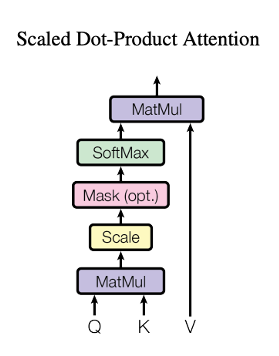

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
  # query ÌÅ¨Í∏∞ : (batch_size, num_heads, queryÏùò Î¨∏Ïû• Í∏∏Ïù¥, d_model/num_heads)
  # key ÌÅ¨Í∏∞ : (batch_size, num_heads, keyÏùò Î¨∏Ïû• Í∏∏Ïù¥, d_model/num_heads)
  # value ÌÅ¨Í∏∞ : (batch_size, num_heads, valueÏùò Î¨∏Ïû• Í∏∏Ïù¥, d_model/num_heads)
  # padding_mask : (batch_size, 1, 1, keyÏùò Î¨∏Ïû• Í∏∏Ïù¥)

  # QÏôÄ KÏùò Í≥±. Ïñ¥ÌÖêÏÖò Ïä§ÏΩîÏñ¥ ÌñâÎ†¨.
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # Ïä§ÏºÄÏùºÎßÅ
  # dkÏùò Î£®Ìä∏Í∞íÏúºÎ°ú ÎÇòÎà†Ï§ÄÎã§.
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # ÎßàÏä§ÌÇπ. Ïñ¥ÌÖêÏÖò Ïä§ÏΩîÏñ¥ ÌñâÎ†¨Ïùò ÎßàÏä§ÌÇπ Ìï† ÏúÑÏπòÏóê Îß§Ïö∞ ÏûëÏùÄ ÏùåÏàòÍ∞íÏùÑ ÎÑ£ÎäîÎã§.
  # Îß§Ïö∞ ÏûëÏùÄ Í∞íÏù¥ÎØÄÎ°ú ÏÜåÌîÑÌä∏Îß•Ïä§ Ìï®ÏàòÎ•º ÏßÄÎÇòÎ©¥ ÌñâÎ†¨Ïùò Ìï¥Îãπ ÏúÑÏπòÏùò Í∞íÏùÄ 0Ïù¥ ÎêúÎã§.
  if mask is not None:
    logits += (mask * -1e9)

  # ÏÜåÌîÑÌä∏Îß•Ïä§ Ìï®ÏàòÎäî ÎßàÏßÄÎßâ Ï∞®ÏõêÏù∏ keyÏùò Î¨∏Ïû• Í∏∏Ïù¥ Î∞©Ìñ•ÏúºÎ°ú ÏàòÌñâÎêúÎã§.
  # attention weight : (batch_size, num_heads, queryÏùò Î¨∏Ïû• Í∏∏Ïù¥, keyÏùò Î¨∏Ïû• Í∏∏Ïù¥)
  attention_weights = tf.nn.softmax(logits, axis=-1)  #(ÏãúÍ∞ÅÌôîÏóê Ïì∞Ïùº Í≤É.->Ïñ¥ÎñªÍ≤å ÌïôÏäµÌïòÍ≥† ÏûàÎäîÏßÄ Î≥¥Ïó¨Ï§Ñ Í≤É)

  # output : (batch_size, num_heads, queryÏùò Î¨∏Ïû• Í∏∏Ïù¥, d_model/num_heads)
  output = tf.matmul(attention_weights, value)

  return output, attention_weights

### MultiHeadAttention

Î©ÄÌã∞ Ìó§Îìú Ïñ¥ÌÖêÏÖòÏóêÏÑúÎäî ÌÅ¨Í≤å Îëê Ï¢ÖÎ•òÏùò Í∞ÄÏ§ëÏπò ÌñâÎ†¨Ïù¥ ÎÇòÏôîÏäµÎãàÎã§. Q, K, V ÌñâÎ†¨ÏùÑ ÎßåÎì§Í∏∞ ÏúÑÌïú Í∞ÄÏ§ëÏπò ÌñâÎ†¨Ïù∏ WQ, WK, WV ÌñâÎ†¨Í≥º Î∞îÎ°ú Ïñ¥ÌÖêÏÖò Ìó§ÎìúÎì§ÏùÑ Ïó∞Í≤∞(concatenation) ÌõÑÏóê Í≥±Ìï¥Ï£ºÎäî WO ÌñâÎ†¨ÏûÖÎãàÎã§.

Î©ÄÌã∞ Ìó§Îìú Ïñ¥ÌÖêÏÖòÏùò Íµ¨ÌòÑÏùÄ ÌÅ¨Í≤å Îã§ÏÑØ Í∞ÄÏßÄ ÌååÌä∏Î°ú Íµ¨ÏÑ±Îê©ÎãàÎã§.

1. WQ, WK, WVÏóê Ìï¥ÎãπÌïòÎäî d_model ÌÅ¨Í∏∞Ïùò Î∞ÄÏßëÏ∏µ(Dense layer)ÏùÑ ÏßÄÎÇòÍ≤åÌïúÎã§.
2. ÏßÄÏ†ïÎêú Ìó§Îìú Ïàò(num_heads)ÎßåÌÅº ÎÇòÎààÎã§(split).
3. Ïä§ÏºÄÏùºÎìú Îã∑ ÌîÑÎ°úÎçïÌä∏ Ïñ¥ÌÖêÏÖò.
4. ÎÇòÎà†Ï°åÎçò Ìó§ÎìúÎì§ÏùÑ Ïó∞Í≤∞(concatenatetion)ÌïúÎã§.
5. WOÏóê Ìï¥ÎãπÌïòÎäî Î∞ÄÏßëÏ∏µÏùÑ ÏßÄÎÇòÍ≤å ÌïúÎã§.


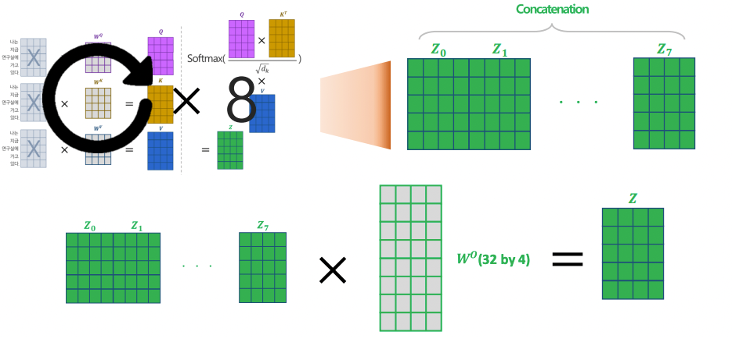

[Ï∞∏Í≥†] python assert    
assertÎäî "Ïù¥ Ï°∞Í±¥Ïù¥ Ï∞∏ÏùºÎïå ÏΩîÎìúÎäî ÎÇ¥Í∞Ä Î≥¥Ïû•ÌïúÎã§. Ïù¥ Ï°∞Í±¥ÏùÄ Ïò¨Î∞îÎ•¥Îã§!   
ÌïòÏßÄÎßå Ïù¥ Ï°∞Í±¥Ïù¥ Í±∞ÏßìÏù¥ÎùºÎäî Í≤ÉÏùÄ ÎÇ¥Í∞Ä Î≥¥Ï¶ùÌïòÏßÄ ÏïäÏùÄ ÎèôÏûëÏù¥Îã§. Í∑∏Îü¨Îãà AssertionErrorÎ•º Î∞úÏÉùÌï¥Îùº!" ÎùºÎäî ÎúªÏûÖÎãàÎã§.

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    # Ïª§Ïä§ÌÖÄ Î†àÏù¥Ïñ¥(Ïö∞Î¶¨ ÏûëÏÑ±ÌïòÎäî layer) -> keras ÏÉùÌÉúÍ≥Ñ ÏïàÏóêÏÑú Ï†úÎåÄÎ°ú ÏûëÎèôÌï† Ïàò ÏûàÍ∏∞ ÎïåÎ¨∏Ïóê ÏîÄ.
    # tf.keras.layers.Layer : Î∂ÄÎ™® ÌÅ¥ÎûòÏä§ -> MultiHeadAttentionÏùÑ kerasÏïàÏóêÏÑú ÏûëÎèôÌïòÍ≤å ÌïòÎ†§Í≥†.
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0
    #assert : Ïù¥ Ï°∞Í±¥Ïù¥ Ï∞∏Ïùº Îïå, ÏΩîÎìúÎäî ÎÇ¥Í∞Ä Î≥¥Ïû•ÌïúÎã§! Î≥¥Ïû•ÌïòÏßÄ ÏïäÏúºÎ©¥ AssertionErrorÎ•º Î∞úÏÉùÌïòÎùº.

    # d_modelÏùÑ num_headsÎ°ú ÎÇòÎàà Í∞í.
    # ÎÖºÎ¨∏ Í∏∞Ï§Ä : 64
    self.depth = d_model // self.num_heads

    # WQ, WK, WVÏóê Ìï¥ÎãπÌïòÎäî Î∞ÄÏßëÏ∏µ Ï†ïÏùò
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    # WOÏóê Ìï¥ÎãπÌïòÎäî Î∞ÄÏßëÏ∏µ Ï†ïÏùò
    self.dense = tf.keras.layers.Dense(units=d_model)

  # num_heads Í∞úÏàòÎßåÌÅº q, k, vÎ•º splitÌïòÎäî Ìï®Ïàò
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))

    # (batch_size, num_heads, queryÏùò Î¨∏Ïû• Í∏∏Ïù¥, d_model/num_heads)
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # 1. WQ, WK, WVÏóê Ìï¥ÎãπÌïòÎäî Î∞ÄÏßëÏ∏µ ÏßÄÎÇòÍ∏∞
    # q : (batch_size, queryÏùò Î¨∏Ïû• Í∏∏Ïù¥, d_model)
    # k : (batch_size, keyÏùò Î¨∏Ïû• Í∏∏Ïù¥, d_model)
    # v : (batch_size, valueÏùò Î¨∏Ïû• Í∏∏Ïù¥, d_model)
    # Ï∞∏Í≥†) Ïù∏ÏΩîÎçî(k, v)-ÎîîÏΩîÎçî(q) Ïñ¥ÌÖêÏÖòÏóêÏÑúÎäî query Í∏∏Ïù¥ÏôÄ key, valueÏùò Í∏∏Ïù¥Îäî Îã§Î•º Ïàò ÏûàÎã§.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 2. Ìó§Îìú ÎÇòÎàÑÍ∏∞
    # q : (batch_size, num_heads, queryÏùò Î¨∏Ïû• Í∏∏Ïù¥, d_model/num_heads)
    # k : (batch_size, num_heads, keyÏùò Î¨∏Ïû• Í∏∏Ïù¥, d_model/num_heads)
    # v : (batch_size, num_heads, valueÏùò Î¨∏Ïû• Í∏∏Ïù¥, d_model/num_heads)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 3. Ïä§ÏºÄÏùºÎìú Îã∑ ÌîÑÎ°úÎçïÌä∏ Ïñ¥ÌÖêÏÖò. ÏïûÏÑú Íµ¨ÌòÑÌïú Ìï®Ïàò ÏÇ¨Ïö©.
    # (batch_size, num_heads, queryÏùò Î¨∏Ïû• Í∏∏Ïù¥, d_model/num_heads)
    scaled_attention, attention_weights = scaled_dot_product_attention(query, key, value, mask)
    # (batch_size, queryÏùò Î¨∏Ïû• Í∏∏Ïù¥, num_heads, d_model/num_heads)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 4. Ìó§Îìú Ïó∞Í≤∞(concatenate)ÌïòÍ∏∞
    # (batch_size, queryÏùò Î¨∏Ïû• Í∏∏Ïù¥, d_model)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 5. WOÏóê Ìï¥ÎãπÌïòÎäî Î∞ÄÏßëÏ∏µ ÏßÄÎÇòÍ∏∞
    # (batch_size, queryÏùò Î¨∏Ïû• Í∏∏Ïù¥, d_model)
    outputs = self.dense(concat_attention)

    return outputs,attention_weights

ÏûÖÎ†•Îêú Ï†ïÏàò ÏãúÌÄÄÏä§ÏóêÏÑú Ìå®Îî© ÌÜ†ÌÅ∞Ïùò Ïù∏Îç±Ïä§Ïù∏ÏßÄ, ÏïÑÎãåÏßÄÎ•º ÌåêÎ≥ÑÌïòÎäî Ìï®ÏàòÎ•º Íµ¨ÌòÑÌïòÎäî Í≤ÉÏûÖÎãàÎã§. ÏïÑÎûòÏùò Ìï®ÏàòÎäî Ï†ïÏàò ÏãúÌÄÄÏä§ÏóêÏÑú 0Ïù∏ Í≤ΩÏö∞ÏóêÎäî 1Î°ú Î≥ÄÌôòÌïòÍ≥†, Í∑∏Î†áÏßÄ ÏïäÏùÄ Í≤ΩÏö∞ÏóêÎäî 0ÏúºÎ°ú Î≥ÄÌôòÌïòÎäî Ìï®ÏàòÏûÖÎãàÎã§.

In [ ]:
# ÏûÖÎ†•Îêú Ï†ïÏàò ÏãúÌÄÄÏä§ÏóêÏÑú Ìå®Îî© ÌÜ†ÌÅ∞Ïùò Ïù∏Îç±Ïä§Ïù∏ÏßÄ, ÏïÑÎãåÏßÄÎ•º ÌåêÎ≥ÑÌïòÎäî Ìï®ÏàòÎ•º Íµ¨ÌòÑÌï¥Î≥¥Ïûê!
# Ï†ïÏàò ÏãúÌÄÄÏä§ÏóêÏÑú 0Ïù∏ Í≤ΩÏö∞ÏóêÎäî 1Î°ú Î≥ÄÌôòÌïòÍ≥†, Í∑∏Î†áÏßÄ ÏïäÏùÄ Í≤ΩÏö∞ÏóêÎäî 0ÏúºÎ°ú Î≥ÄÌôòÌïòÎäî Ìï®Ïàò.
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, keyÏùò Î¨∏Ïû• Í∏∏Ïù¥)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
# ÏòàÏãú
print(create_padding_mask(tf.constant([[1, 21, 777, 0, 0]])))

tf.Tensor([[[[0. 0. 0. 1. 1.]]]], shape=(1, 1, 1, 5), dtype=float32)


### Ïù∏ÏΩîÎçî

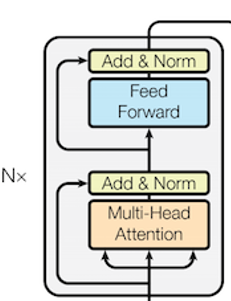

ÌïòÎÇòÏùò Ïù∏ÏΩîÎçî Î∏îÎ°ù. Ï¶â, ÌïòÎÇòÏùò Ïù∏ÏΩîÎçî Ï∏µÏùÑ Íµ¨ÌòÑÌïòÎäî ÏΩîÎìúÏûÖÎãàÎã§.

In [ ]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # Ïù∏ÏΩîÎçîÎäî Ìå®Îî© ÎßàÏä§ÌÅ¨ ÏÇ¨Ïö© -> Ïñ¥ÌÖêÏÖòÏóêÏÑú Ìå®Îî© ÌÜ†ÌÅ∞ Ï†úÏô∏
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # Î©ÄÌã∞-Ìó§Îìú Ïñ¥ÌÖêÏÖò (Ï≤´Î≤àÏß∏ ÏÑúÎ∏åÏ∏µ / ÏÖÄÌîÑ Ïñ¥ÌÖêÏÖò)
  attention, _ = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # Ìå®Îî© ÎßàÏä§ÌÅ¨ ÏÇ¨Ïö©
      })
  # self-attentionÏóêÏÑú Q=K=VÏù∏ Ïù¥Ïú†?
  # self-attention : Í∞Å Îã®Ïñ¥(Query)Í∞Ä Î¨∏Ïû• ÎÇ¥ Îã§Î•∏ Î™®Îì† Îã®Ïñ¥(key)ÏôÄÏùò Í¥ÄÎ†®ÏÑ±(Ïú†ÏÇ¨ÎèÑ)Î•º Í≥ÑÏÇ∞.
  # Í¥ÄÎ†®Îêú Îã®Ïñ¥Ïùò Ï†ïÎ≥¥(Value)Î•º Ï¢ÖÌï©Ìï¥ ÏÉàÎ°úÏö¥ ÌëúÌòÑÏúºÎ°ú ÎÇòÌÉúÎäî Íµ¨Ï°∞
  # ÌïòÎÇòÏùò ÏûÖÎ†• ÏãúÌÄÄÏä§Ïùò Í∏∞Ï§ÄÏúºÎ°ú Î™®Îì† Îã®Ïñ¥Í∞Ä ÏÑúÎ°ú ÎπÑÍµêÎêòÏñ¥Ïïº ÌïòÎØÄÎ°ú Q=K=V
  # Q not= K not=V -> cross attention (self attention->Encoder-Decoder AttentionÏùÑ ÏÇ¨Ïö©Ìï®.)

  # ÎìúÎ°≠ÏïÑÏõÉ + ÏûîÏ∞® Ïó∞Í≤∞Í≥º Ï∏µ Ï†ïÍ∑úÌôî
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # Ìè¨ÏßÄÏÖò ÏôÄÏù¥Ï¶à ÌîºÎìú Ìè¨ÏõåÎìú Ïã†Í≤ΩÎßù (ÎëêÎ≤àÏß∏ ÏÑúÎ∏åÏ∏µ)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # ÎìúÎ°≠ÏïÑÏõÉ + ÏûîÏ∞® Ïó∞Í≤∞Í≥º Ï∏µ Ï†ïÍ∑úÌôî
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

Ïã§Ï†úÎ°ú Ìä∏ÎûúÏä§Ìè¨Î®∏Îäî num_layers Í∞úÏàòÎßåÌÅºÏùò Ïù∏ÏΩîÎçî Ï∏µÏùÑ ÏÇ¨Ïö©ÌïòÎØÄÎ°ú Ïù¥Î•º Ïó¨Îü¨Î≤à ÏåìÎäî ÏΩîÎìúÎ•º Î≥ÑÎèÑ Íµ¨ÌòÑÌï©ÎãàÎã§.

In [ ]:
def encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # Ïù∏ÏΩîÎçîÎäî Ìå®Îî© ÎßàÏä§ÌÅ¨ ÏÇ¨Ïö©
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # Ìè¨ÏßÄÏÖîÎÑê Ïù∏ÏΩîÎî© + ÎìúÎ°≠ÏïÑÏõÉ
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  # d_model Ï∞®ÏõêÏùò Î∞ÄÏßë Î≤°ÌÑ∞Î°ú Î≥ÄÌôò
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  # TransformerÏóêÏÑúÎäî ÎÇ¥Ï†Å(dot prodct) Í∏∞Î∞òÏùò Ïó∞ÏÇ∞Ïù¥ ÎßéÍ∏∞ ÎïåÎ¨∏Ïóê -> Ïä§ÏºÄÏùºÏùÑ Î≥¥Ï†ï.
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  # Îã®Ïñ¥ ÏûÑÎ≤†Îî©ÏóêÎäî ÏàúÏÑúÍ∞Ä ÏóÜÏùå / Í∞Å Îã®Ïñ¥Ïùò ÏúÑÏπò Ï†ïÎ≥¥Î•º Ï∂îÍ∞ÄÌï®(sin, cos Í∏∞Î∞ò)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # Ïù∏ÏΩîÎçîÎ•º num_layersÍ∞ú ÏåìÍ∏∞
  for i in range(num_layers):
    outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

### ÎîîÏΩîÎçî

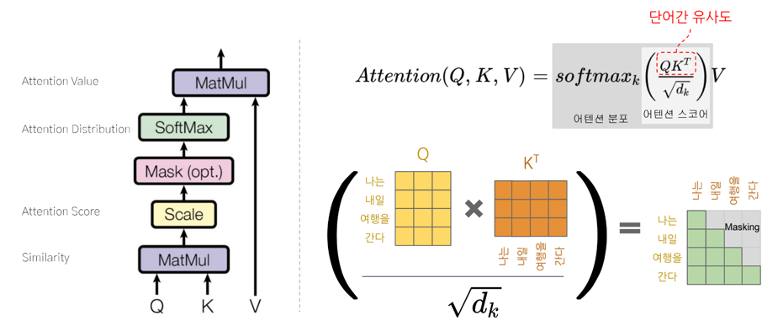

In [ ]:
# ÎîîÏΩîÎçîÏùò Ï≤´Î≤àÏß∏ ÏÑúÎ∏åÏ∏µ(sublayer)ÏóêÏÑú ÎØ∏Îûò ÌÜ†ÌÅ∞ÏùÑ MaskÌïòÎäî Ìï®Ïàò
# ÎîîÏΩîÎçî self-attention -> ÎØ∏Îûò ÌÜ†ÌÅ∞ Í∞ÄÎ¶º+ÎèôÏãúÏóê Ìå®Îî©(<PAD> Î¨¥Ïãú)->combine mask ÏÉùÏÑ±
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  # ÏûÖÎ†• ÌÖêÏÑú xÏùò ÏãúÌÄÄÏä§ Í∏∏Ïù¥(Ïòà,[batch,5] -> seq_len=5)
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len,seq_len)),-1,0)
  # tf.ones((seq_len,seq_len)) : Ï†ÑÏ≤¥Í∞Ä 1Î°ú Ï±ÑÏõåÏßÑ Ï†ïÎ∞©ÌñâÎ†¨
  #tf.linalg.band_part(...,-1,0) : ÌïòÏÇºÍ∞Å ÌñâÎ†¨Îßå ÎÇ®Í∏∞Í≥† ÎÇòÎ®∏ÏßÄÎ•º 0ÏúºÎ°ú ÎßåÎì¶.
  # 1- .... : ÏÉÅÏÇºÍ∞Å = ÎØ∏ÎûòÎ•º ÏùòÎØ∏ -> ÎØ∏Îûò ÎßàÏä§ÌÇπ.
  padding_mask = create_padding_mask(x)
  # shape : [batch_size,1,1,seq_len]  : ÏûÖÎ†• ÏãúÌÄÄÏä§ xÏóêÏÑú Ìå®Îî© ÌÜ†ÌÅ∞(0)Ï∞æÏïÑ ÎßàÏä§ÌÅ¨ ÏÉùÏÑ±.
  return tf.maximum(look_ahead_mask,padding_mask)
  #Îëê ÎßàÏä§ÌÅ¨ Ï§ë ÌïòÎÇòÎùºÎèÑ ÎßàÏä§ÌÇπÏù¥Î©¥ -> ÏµúÏ¢ÖÏ†ÅÏúºÎ°ú ÎßàÏä§ÌÅ¨.

In [ ]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))


tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


ÏûÑÏùòÏùò Ï†ïÏàò ÏãúÌÄÄÏä§ ÏûÖÎ†•ÏùÑ ÎÑ£Ïñ¥ÏÑú Í≤∞Í≥ºÎ•º Î¥ÖÏãúÎã§. Ìå®Îî© ÎßàÏä§ÌÅ¨Î•º ÌÖåÏä§Ìä∏ ÌïòÍ∏∞ÏúÑÌï¥ ÏÑ∏Î≤àÏß∏ ÏúÑÏπòÏóê Ï†ïÏàò 0ÏùÑ ÎÑ£ÏóàÏäµÎãàÎã§. Î£©-Ïñ¥Ìó§Îìú ÎßàÏä§ÌÅ¨Ïù¥ÎØÄÎ°ú ÏÇºÍ∞ÅÌòï Î™®ÏñëÏùò ÎßàÏä§ÌÇπÏù¥ ÌòïÏÑ±ÎêòÎ©¥ÏÑú Ìå®Îî© ÎßàÏä§ÌÅ¨Í∞Ä Ìè¨Ìï®ÎêòÏñ¥Ï†∏ ÏûàÎäî ÏÑ∏Î≤àÏß∏ Ïó¥Ïù¥ ÎßàÏä§ÌÇπÎê©ÎãàÎã§.

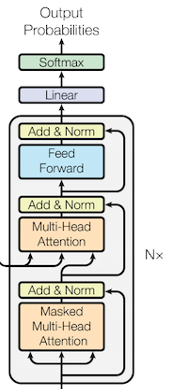

In [ ]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

  # ÎîîÏΩîÎçîÎäî Î£©Ïñ¥Ìó§Îìú ÎßàÏä§ÌÅ¨(Ï≤´Î≤àÏß∏ ÏÑúÎ∏åÏ∏µ)ÏôÄ Ìå®Îî© ÎßàÏä§ÌÅ¨(ÎëêÎ≤àÏß∏ ÏÑúÎ∏åÏ∏µ) Îëò Îã§ ÏÇ¨Ïö©.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # Î©ÄÌã∞-Ìó§Îìú Ïñ¥ÌÖêÏÖò (Ï≤´Î≤àÏß∏ ÏÑúÎ∏åÏ∏µ / ÎßàÏä§ÌÅ¨Îìú ÏÖÄÌîÑ Ïñ¥ÌÖêÏÖò)
  attention1,_ = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': look_ahead_mask # Î£©Ïñ¥Ìó§Îìú ÎßàÏä§ÌÅ¨(Î£©Ïñ¥Ìó§Îìú + Ìå®Îî©)
      })

  # ÏûîÏ∞® Ïó∞Í≤∞Í≥º Ï∏µ Ï†ïÍ∑úÌôî
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # Î©ÄÌã∞-Ìó§Îìú Ïñ¥ÌÖêÏÖò (ÎëêÎ≤àÏß∏ ÏÑúÎ∏åÏ∏µ / ÎîîÏΩîÎçî-Ïù∏ÏΩîÎçî Ïñ¥ÌÖêÏÖò)
  attention2,_ = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
          'mask': padding_mask # Ìå®Îî© ÎßàÏä§ÌÅ¨
      })

  # ÎìúÎ°≠ÏïÑÏõÉ + ÏûîÏ∞® Ïó∞Í≤∞Í≥º Ï∏µ Ï†ïÍ∑úÌôî
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # Ìè¨ÏßÄÏÖò ÏôÄÏù¥Ï¶à ÌîºÎìú Ìè¨ÏõåÎìú Ïã†Í≤ΩÎßù (ÏÑ∏Î≤àÏß∏ ÏÑúÎ∏åÏ∏µ)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # ÎìúÎ°≠ÏïÑÏõÉ + ÏûîÏ∞® Ïó∞Í≤∞Í≥º Ï∏µ Ï†ïÍ∑úÌôî
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

Ìè¨ÏßÄÏÖîÎÑê Ïù∏ÏΩîÎî© ÌõÑ ÎîîÏΩîÎçî Ï∏µÏùÑ num_layersÏùò Í∞úÏàòÎßåÌÅº ÏåìÎäî ÏΩîÎìúÏûÖÎãàÎã§.

In [ ]:
def decoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

  # ÎîîÏΩîÎçîÎäî Î£©Ïñ¥Ìó§Îìú ÎßàÏä§ÌÅ¨(Ï≤´Î≤àÏß∏ ÏÑúÎ∏åÏ∏µ)ÏôÄ Ìå®Îî© ÎßàÏä§ÌÅ¨(ÎëêÎ≤àÏß∏ ÏÑúÎ∏åÏ∏µ) Îëò Îã§ ÏÇ¨Ïö©.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # Ìè¨ÏßÄÏÖîÎÑê Ïù∏ÏΩîÎî© + ÎìúÎ°≠ÏïÑÏõÉ
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # ÎîîÏΩîÎçîÎ•º num_layersÍ∞ú ÏåìÍ∏∞
  for i in range(num_layers):
    outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

### Ìä∏ÎûúÏä§Ìè¨Î®∏ Íµ¨ÌòÑÌïòÍ∏∞

ÏßÄÍ∏àÍπåÏßÄ Íµ¨ÌòÑÌïú Ïù∏ÏΩîÎçîÏôÄ ÎîîÏΩîÎçî Ìï®ÏàòÎ•º Ï°∞Ìï©ÌïòÏó¨ Ìä∏ÎûúÏä§Ìè¨Î®∏Î•º Ï°∞Î¶ΩÌï† Ï∞®Î°ÄÏûÖÎãàÎã§. Ïù∏ÏΩîÎçîÏùò Ï∂úÎ†•ÏùÄ ÎîîÏΩîÎçîÏóêÏÑú Ïù∏ÏΩîÎçî-ÎîîÏΩîÎçî Ïñ¥ÌÖêÏÖòÏóêÏÑú ÏÇ¨Ïö©ÎêòÍ∏∞ ÏúÑÌï¥ ÎîîÏΩîÎçîÎ°ú Ï†ÑÎã¨Ìï¥Ï§çÎãàÎã§. Í∑∏Î¶¨Í≥† ÎîîÏΩîÎçîÏùò ÎÅùÎã®ÏóêÎäî Îã§Ï§ë ÌÅ¥ÎûòÏä§ Î∂ÑÎ•ò Î¨∏Ï†úÎ•º ÌíÄ Ïàò ÏûàÎèÑÎ°ù, vocab_size ÎßåÌÅºÏùò Îâ¥Îü∞ÏùÑ Í∞ÄÏßÄÎäî Ï∂úÎ†•Ï∏µÏùÑ Ï∂îÍ∞ÄÌï¥Ï§çÎãàÎã§.

In [ ]:
def transformer(vocab_size, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

  # Ïù∏ÏΩîÎçîÏùò ÏûÖÎ†•
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # ÎîîÏΩîÎçîÏùò ÏûÖÎ†•
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # Ïù∏ÏΩîÎçîÏùò Ìå®Îî© ÎßàÏä§ÌÅ¨
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # ÎîîÏΩîÎçîÏùò Î£©Ïñ¥Ìó§Îìú ÎßàÏä§ÌÅ¨(Ï≤´Î≤àÏß∏ ÏÑúÎ∏åÏ∏µ)
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # ÎîîÏΩîÎçîÏùò Ìå®Îî© ÎßàÏä§ÌÅ¨(ÎëêÎ≤àÏß∏ ÏÑúÎ∏åÏ∏µ)
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

##################################################################

  # Ïù∏ÏΩîÎçîÏùò Ï∂úÎ†•ÏùÄ enc_outputs. ÎîîÏΩîÎçîÎ°ú Ï†ÑÎã¨ÎêúÎã§.
  enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )([inputs, enc_padding_mask]) # Ïù∏ÏΩîÎçîÏùò ÏûÖÎ†•ÏùÄ ÏûÖÎ†• Î¨∏Ïû•Í≥º Ìå®Îî© ÎßàÏä§ÌÅ¨

  # ÎîîÏΩîÎçîÏùò Ï∂úÎ†•ÏùÄ dec_outputs. Ï∂úÎ†•Ï∏µÏúºÎ°ú Ï†ÑÎã¨ÎêúÎã§.
  dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )([dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # Îã§Ïùå Îã®Ïñ¥ ÏòàÏ∏°ÏùÑ ÏúÑÌïú Ï∂úÎ†•Ï∏µ
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

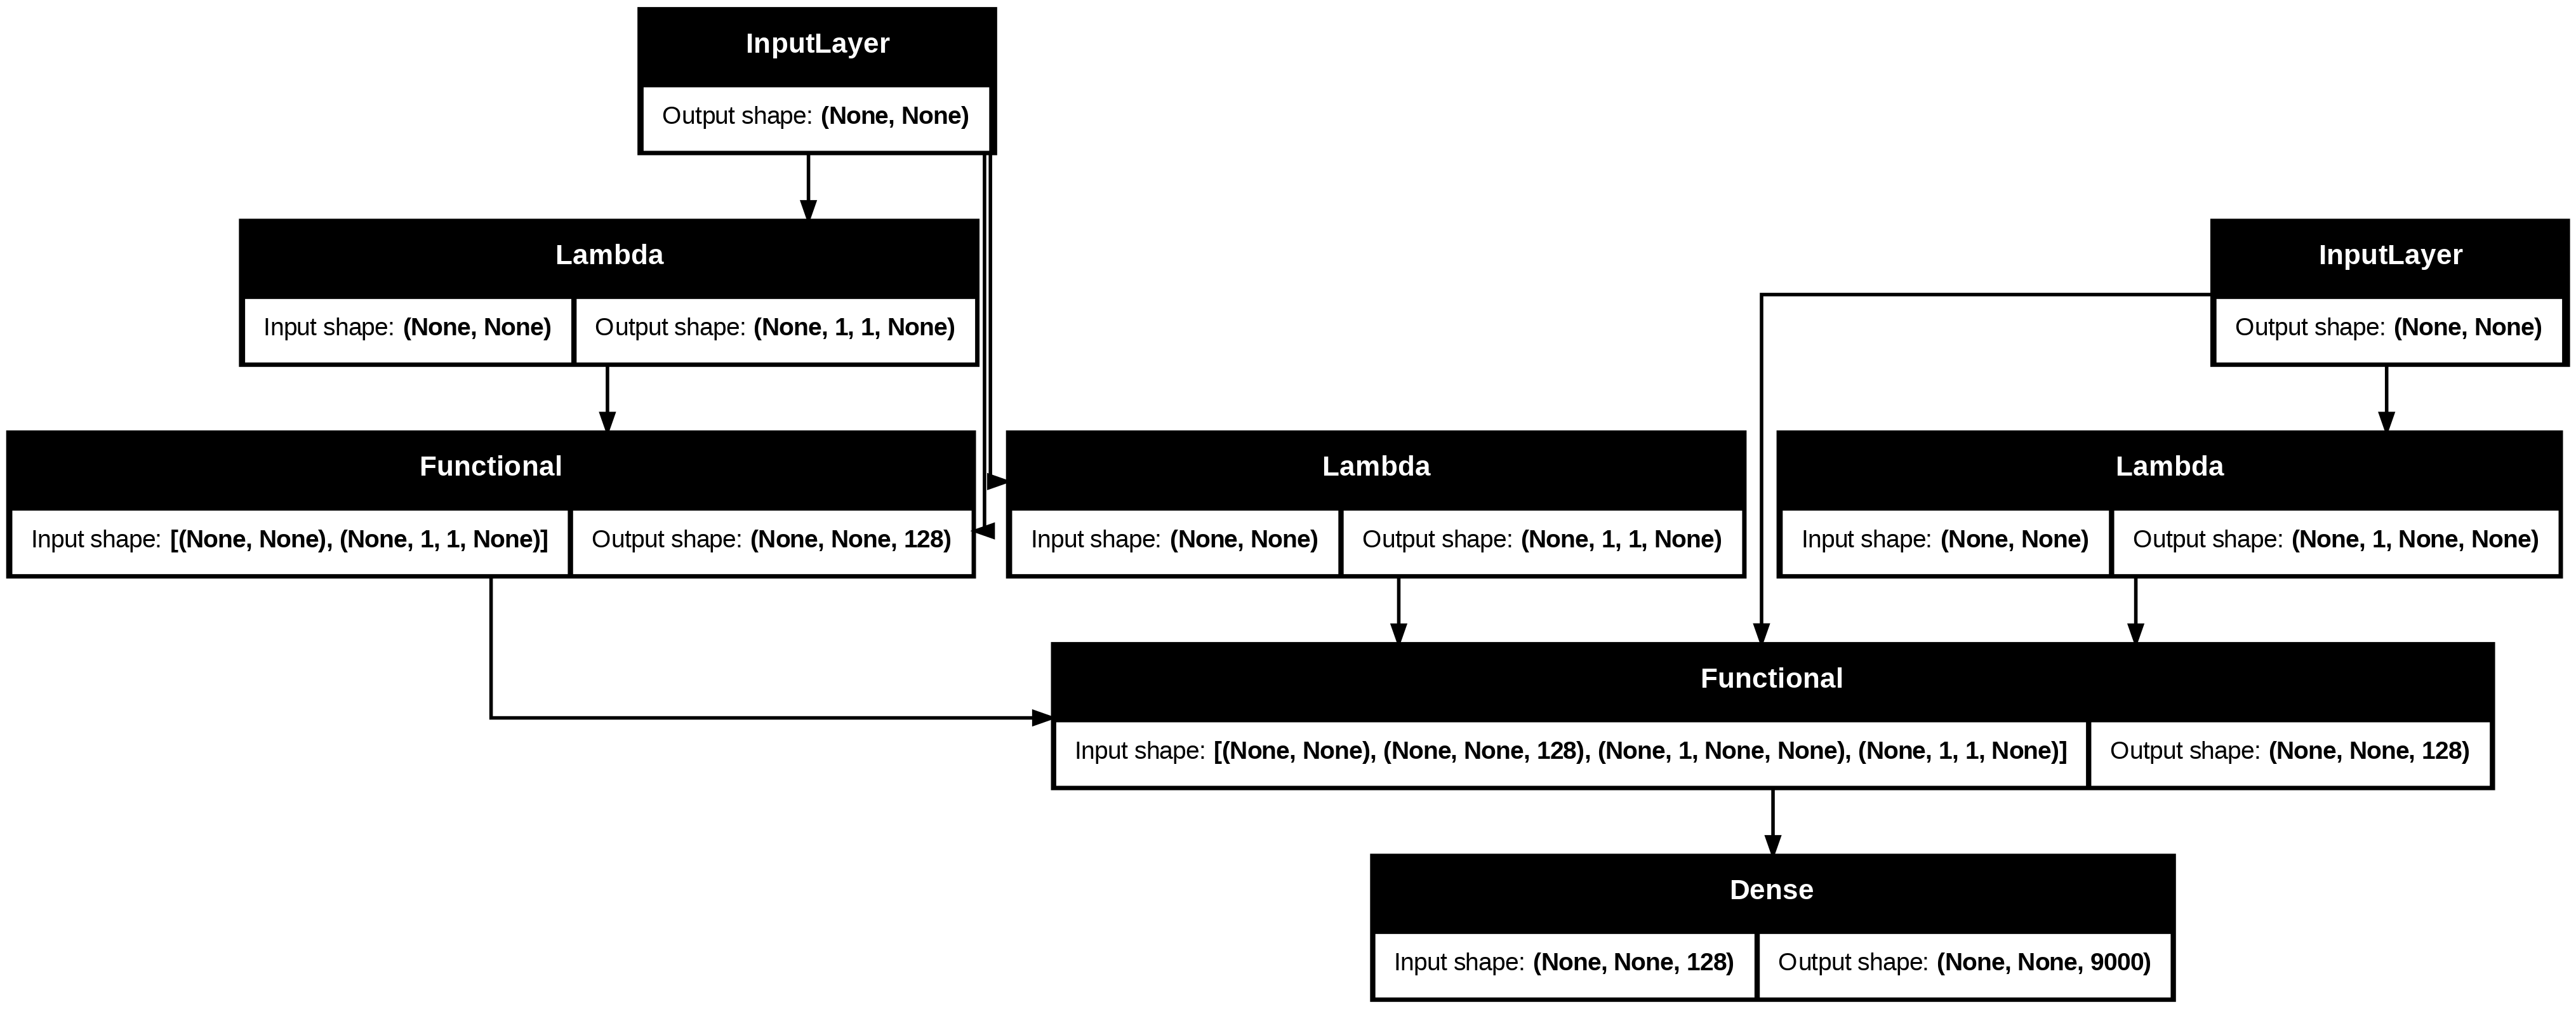

In [ ]:
small_transformer = transformer(
    vocab_size = 9000,
    num_layers = 4,
    dff = 512,
    d_model = 128,
    num_heads = 4,
    dropout = 0.3,
    name="small_transformer")

tf.keras.utils.plot_model(
    small_transformer, to_file='small_transformer.png', show_shapes=True)

In [ ]:
y_true = 1
tf.cast(tf.not_equal(y_true, 0), tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32) # y_trueÍ∞Ä 0(Ìå®Îî©Ïù¥Î©¥) -> 0 , 1Ïù¥Î©¥ -> 1
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss) #Computes the mean of elements across dimensions of a tensor.

ÌïôÏäµÎ•† Ïä§ÏºÄÏ§ÑÎü¨(Learning rate Scheduler)Îäî ÎØ∏Î¶¨ ÌïôÏäµ ÏùºÏ†ïÏùÑ Ï†ïÌï¥ÎëêÍ≥† Í∑∏ ÏùºÏ†ïÏóê Îî∞Îùº ÌïôÏäµÎ•†Ïù¥ Ï°∞Ï†ïÎêòÎäî Î∞©Î≤ïÏûÖÎãàÎã§. Ìä∏ÎûúÏä§Ìè¨Î®∏Ïùò Í≤ΩÏö∞ ÏÇ¨Ïö©ÏûêÍ∞Ä Ï†ïÌïú Îã®Í≥ÑÍπåÏßÄÎäî ÌïôÏäµÎ•†ÏùÑ Ï¶ùÍ∞ÄÏãúÏº∞Îã§Í∞Ä Îã®Í≥ÑÏóê Ïù¥Î•¥Î©¥ ÌïôÏäµÎ•†ÏùÑ Ï†êÏ∞®Ï†ÅÏúºÎ°ú Îñ®Ïñ¥Ìä∏Î¶¨Îäî Î∞©ÏãùÏùÑ ÏÇ¨Ïö©Ìï©ÎãàÎã§.

Ìä∏ÎûúÏä§Ìè¨Î®∏ÏóêÏÑúÎäî warmup_stepsÏù¥ÎùºÎäî Î≥ÄÏàòÎ•º Ï†ïÌïòÍ≥† step_numÏù¥ warmup_stepsÎ≥¥Îã§ ÏûëÏùÑ Í≤ΩÏö∞Îäî ÌïôÏäµÎ•†ÏùÑ ÏÑ†ÌòïÏ†ÅÏúºÎ°ú Ï¶ùÍ∞Ä ÏãúÌÇ§Í≥†, step_numÏù¥ warmup_stepsÏóê ÎèÑÎã¨ÌïòÍ≤å ÎêòÎ©¥ ÌïôÏäµÎ•†ÏùÑ step_numÏùò Ïó≠Ï†úÍ≥±Í∑ºÏóê Îî∞ÎùºÏÑú Í∞êÏÜåÏãúÌÇµÎãàÎã§.

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

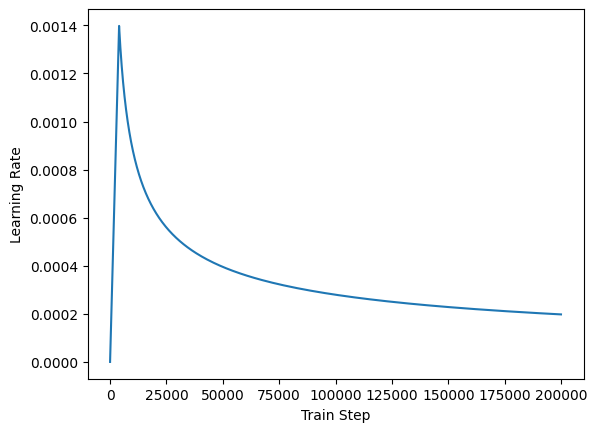

In [ ]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

Ï∞∏Í≥† : [Ïñ∏Ïñ¥ Ïù¥Ìï¥Î•º ÏúÑÌïú Î≥ÄÌôòÍ∏∞ Î™®Îç∏](https://www.tensorflow.org/text/tutorials/transformer?hl=ko)

# Ï±óÎ¥á Íµ¨ÌòÑ

Ï∂úÏ≤ò : Îî•Îü¨ÎãùÏùÑ Ïù¥Ïö©Ìïú ÏûêÏó∞Ïñ¥ Ï≤òÎ¶¨ ÏûÖÎ¨∏

In [ ]:
import pandas as pd
import urllib.request
import tensorflow_datasets as tfds
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt
import re

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatBotData.csv")

train_data = pd.read_csv('ChatBotData.csv')
train_data.head()

Q            A  label
0           12Ïãú Îï°!   ÌïòÎ£®Í∞Ä Îòê Í∞ÄÎÑ§Ïöî.      0
1      1ÏßÄÎßù ÌïôÍµê Îñ®Ïñ¥Ï°åÏñ¥    ÏúÑÎ°úÌï¥ ÎìúÎ¶ΩÎãàÎã§.      0
2     3Î∞ï4Ïùº ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Îã§  Ïó¨ÌñâÏùÄ Ïñ∏Ï†úÎÇò Ï¢ãÏ£†.      0
3  3Î∞ï4Ïùº Ï†ïÎèÑ ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Îã§  Ïó¨ÌñâÏùÄ Ïñ∏Ï†úÎÇò Ï¢ãÏ£†.      0
4          PPL Ïã¨ÌïòÎÑ§   ÎààÏÇ¥Ïù¥ Ï∞åÌë∏Î†§ÏßÄÏ£†.      0

In [ ]:
print('Ï±óÎ¥á ÏÉòÌîåÏùò Í∞úÏàò :', len(train_data))

Ï±óÎ¥á ÏÉòÌîåÏùò Í∞úÏàò : 11823


In [ ]:
print(train_data.isnull().sum())

Q        0
A        0
label    0
dtype: int64


In [ ]:
questions = []
for sentence in train_data['Q']:
    # Íµ¨ÎëêÏ†êÏóê ÎåÄÌï¥ÏÑú ÎùÑÏñ¥Ïì∞Í∏∞
    # ex) 12Ïãú Îï°! -> 12Ïãú Îï° !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    questions.append(sentence)

In [ ]:
answers = []
for sentence in train_data['A']:
    # Íµ¨ÎëêÏ†êÏóê ÎåÄÌï¥ÏÑú ÎùÑÏñ¥Ïì∞Í∏∞
    # ex) 12Ïãú Îï°! -> 12Ïãú Îï° !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    answers.append(sentence)

In [ ]:
len(questions)

11823

In [ ]:
print(questions[:5])
print(answers[:5])

['12Ïãú Îï° !', '1ÏßÄÎßù ÌïôÍµê Îñ®Ïñ¥Ï°åÏñ¥', '3Î∞ï4Ïùº ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Îã§', '3Î∞ï4Ïùº Ï†ïÎèÑ ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Îã§', 'PPL Ïã¨ÌïòÎÑ§']
['ÌïòÎ£®Í∞Ä Îòê Í∞ÄÎÑ§Ïöî .', 'ÏúÑÎ°úÌï¥ ÎìúÎ¶ΩÎãàÎã§ .', 'Ïó¨ÌñâÏùÄ Ïñ∏Ï†úÎÇò Ï¢ãÏ£† .', 'Ïó¨ÌñâÏùÄ Ïñ∏Ï†úÎÇò Ï¢ãÏ£† .', 'ÎààÏÇ¥Ïù¥ Ï∞åÌë∏Î†§ÏßÄÏ£† .']


In [ ]:
# ÏÑúÎ∏åÏõåÎìúÌÖçÏä§Ìä∏Ïù∏ÏΩîÎçîÎ•º ÏÇ¨Ïö©ÌïòÏó¨ ÏßàÎ¨∏Í≥º ÎãµÎ≥ÄÏùÑ Î™®Îëê Ìè¨Ìï®Ìïú Îã®Ïñ¥ ÏßëÌï©(Vocabulary) ÏÉùÏÑ±
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

# ÏãúÏûë ÌÜ†ÌÅ∞Í≥º Ï¢ÖÎ£å ÌÜ†ÌÅ∞Ïóê ÎåÄÌïú Ï†ïÏàò Î∂ÄÏó¨.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# ÏãúÏûë ÌÜ†ÌÅ∞Í≥º Ï¢ÖÎ£å ÌÜ†ÌÅ∞ÏùÑ Í≥†Î†§ÌïòÏó¨ Îã®Ïñ¥ ÏßëÌï©Ïùò ÌÅ¨Í∏∞Î•º + 2
VOCAB_SIZE = tokenizer.vocab_size + 2

In [ ]:
print('ÏãúÏûë ÌÜ†ÌÅ∞ Î≤àÌò∏ :',START_TOKEN)
print('Ï¢ÖÎ£å ÌÜ†ÌÅ∞ Î≤àÌò∏ :',END_TOKEN)
print('Îã®Ïñ¥ ÏßëÌï©Ïùò ÌÅ¨Í∏∞ :',VOCAB_SIZE)

ÏãúÏûë ÌÜ†ÌÅ∞ Î≤àÌò∏ : [8178]
Ï¢ÖÎ£å ÌÜ†ÌÅ∞ Î≤àÌò∏ : [8179]
Îã®Ïñ¥ ÏßëÌï©Ïùò ÌÅ¨Í∏∞ : 8180


In [ ]:
# ÏÑúÎ∏åÏõåÎìúÌÖçÏä§Ìä∏Ïù∏ÏΩîÎçî ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†ÄÏùò .encode()Î•º ÏÇ¨Ïö©ÌïòÏó¨ ÌÖçÏä§Ìä∏ ÏãúÌÄÄÏä§Î•º Ï†ïÏàò ÏãúÌÄÄÏä§Î°ú Î≥ÄÌôò.
print('Tokenized sample question: {}'.format(tokenizer.encode(questions[20])))

Tokenized sample question: [5766, 611, 3509, 141, 685, 3747, 849]


In [ ]:
# ÏÑúÎ∏åÏõåÎìúÌÖçÏä§Ìä∏Ïù∏ÏΩîÎçî ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†ÄÏùò .encode()ÏôÄ decode() ÌÖåÏä§Ìä∏Ìï¥Î≥¥Í∏∞

# ÏûÑÏùòÏùò ÏûÖÎ†• Î¨∏Ïû•ÏùÑ sample_stringÏóê Ï†ÄÏû•
sample_string = questions[20]

# encode() : ÌÖçÏä§Ìä∏ ÏãúÌÄÄÏä§ --> Ï†ïÏàò ÏãúÌÄÄÏä§
tokenized_string = tokenizer.encode(sample_string)
print ('Ï†ïÏàò Ïù∏ÏΩîÎî© ÌõÑÏùò Î¨∏Ïû• {}'.format(tokenized_string))

# decode() : Ï†ïÏàò ÏãúÌÄÄÏä§ --> ÌÖçÏä§Ìä∏ ÏãúÌÄÄÏä§
original_string = tokenizer.decode(tokenized_string)
print ('Í∏∞Ï°¥ Î¨∏Ïû•: {}'.format(original_string))

Ï†ïÏàò Ïù∏ÏΩîÎî© ÌõÑÏùò Î¨∏Ïû• [5766, 611, 3509, 141, 685, 3747, 849]
Í∏∞Ï°¥ Î¨∏Ïû•: Í∞ÄÏä§ÎπÑ ÎπÑÏãºÎç∞ Í∞êÍ∏∞ Í±∏Î¶¨Í≤†Ïñ¥


In [ ]:
# Í∞Å Ï†ïÏàòÎäî Í∞Å Îã®Ïñ¥ÏôÄ Ïñ¥ÎñªÍ≤å mappingÎêòÎäîÏßÄ Î≥ëÎ†¨Î°ú Ï∂úÎ†•
# ÏÑúÎ∏åÏõåÎìúÌÖçÏä§Ìä∏Ïù∏ÏΩîÎçîÎäî ÏùòÎØ∏ÏûàÎäî Îã®ÏúÑÏùò ÏÑúÎ∏åÏõåÎìúÎ°ú ÌÜ†ÌÅ¨ÎÇòÏù¥ÏßïÌïúÎã§. ÎùÑÏñ¥Ïì∞Í∏∞ Îã®ÏúÑ X ÌòïÌÉúÏÜå Î∂ÑÏÑù Îã®ÏúÑ X
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

5766 ----> Í∞ÄÏä§
611 ----> ÎπÑ 
3509 ----> ÎπÑÏãº
141 ----> Îç∞ 
685 ----> Í∞êÍ∏∞ 
3747 ----> Í±∏Î¶¨
849 ----> Í≤†Ïñ¥


In [ ]:
# ÏµúÎåÄ Í∏∏Ïù¥Î•º 40ÏúºÎ°ú Ï†ïÏùò
MAX_LENGTH = 40

# ÌÜ†ÌÅ∞Ìôî / Ï†ïÏàò Ïù∏ÏΩîÎî© / ÏãúÏûë ÌÜ†ÌÅ∞Í≥º Ï¢ÖÎ£å ÌÜ†ÌÅ∞ Ï∂îÍ∞Ä / Ìå®Îî©
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # encode(ÌÜ†ÌÅ∞Ìôî + Ï†ïÏàò Ïù∏ÏΩîÎî©), ÏãúÏûë ÌÜ†ÌÅ∞Í≥º Ï¢ÖÎ£å ÌÜ†ÌÅ∞ Ï∂îÍ∞Ä
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)

  # Ìå®Îî©
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs

In [ ]:
tokenized_questions, tokenized_answers = tokenize_and_filter(questions, answers)

In [ ]:
tokenized_questions, tokenized_answers = tokenize_and_filter(questions, answers)
tokenized_questions = np.array(tokenized_questions, dtype=np.int32)
tokenized_answers = np.array(tokenized_answers, dtype=np.int32)

In [ ]:
# ÌÖêÏÑúÌîåÎ°úÏö∞ datasetÏùÑ Ïù¥Ïö©ÌïòÏó¨ ÏÖîÌîå(shuffle)ÏùÑ ÏàòÌñâÌïòÎêò, Î∞∞Ïπò ÌÅ¨Í∏∞Î°ú Îç∞Ïù¥ÌÑ∞Î•º Î¨∂ÎäîÎã§.
# ÎòêÌïú Ïù¥ Í≥ºÏ†ïÏóêÏÑú ÍµêÏÇ¨ Í∞ïÏöî(teacher forcing)ÏùÑ ÏÇ¨Ïö©ÌïòÍ∏∞ ÏúÑÌï¥ÏÑú ÎîîÏΩîÎçîÏùò ÏûÖÎ†•Í≥º Ïã§Ï†úÍ∞í ÏãúÌÄÄÏä§Î•º Íµ¨ÏÑ±ÌïúÎã§.
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# ÎîîÏΩîÎçîÏùò Ïã§Ï†úÍ∞í ÏãúÌÄÄÏä§ÏóêÏÑúÎäî ÏãúÏûë ÌÜ†ÌÅ∞ÏùÑ Ï†úÍ±∞Ìï¥Ïïº ÌïúÎã§.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': tokenized_questions,
        'dec_inputs': tokenized_answers[:, :-1] # ÎîîÏΩîÎçîÏùò ÏûÖÎ†•. ÎßàÏßÄÎßâ Ìå®Îî© ÌÜ†ÌÅ∞Ïù¥ Ï†úÍ±∞ÎêúÎã§.
    },
    {
        'outputs': tokenized_answers[:, 1:] # Îß® Ï≤òÏùå ÌÜ†ÌÅ∞Ïù¥ Ï†úÍ±∞ÎêúÎã§. Îã§Ïãú ÎßêÌï¥ ÏãúÏûë ÌÜ†ÌÅ∞Ïù¥ Ï†úÍ±∞ÎêúÎã§.
    }
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
for batch in dataset.take(1):
    print(batch[0]['inputs'].dtype)  # tf.int32
    print(batch[1]['outputs'].dtype) # tf.int32

<dtype: 'int32'>
<dtype: 'int32'>


In [ ]:
# Hyper-parameters
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [ ]:
MAX_LENGTH = 40

# ÏÜêÏã§ Ìï®Ïàò Ï†ïÏùò
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int32)  # Ï†ïÎãµÏùÄ int32Î°ú Ï∫êÏä§ÌåÖ
    loss = loss_object(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, 0), dtype=loss.dtype)
    loss *= mask
    return tf.reduce_mean(loss)  # Î∞òÎìúÏãú float32 Î∞òÌôò

# Ï†ïÌôïÎèÑ Ìï®Ïàò Ï†ïÏùò
def accuracy(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int32)
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)  # ÌÖêÏÑú Î∞òÌôò

# ÏòµÌã∞ÎßàÏù¥Ï†Ä
optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Ïª¥ÌååÏùº
model.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=[accuracy]  # Î¨∏ÏûêÏó¥ "accuracy"Í∞Ä ÏïÑÎãò!
)

In [ ]:
model.fit(dataset, epochs=20)

Epoch 1/20


TypeError: Expected float32, but got outputs of type 'str'.

## üö® Î¨∏Ï†ú ÏöîÏïΩ

KerasÏùò `model.fit(x, y)` ÎÇ¥Î∂ÄÏóêÎäî  
`tf.nest.flatten`Í≥º `tree_map`ÏùÑ ÏÇ¨Ïö©Ìï¥ **ÏûÖÎ†• Íµ¨Ï°∞(tree)** Î•º ÌéºÏπòÍ≥†(‚Äïflatten‚Äï)  
Î™®Îì† ‚ÄúÏûéÏÇ¨Í∑Ä(leaf)‚ÄùÏóê Ìï®ÏàòÎ•º Ï†ÅÏö©Ìï©ÎãàÎã§.  

- **dict Íµ¨Ï°∞** (`{ 'inputs':‚Ä¶, 'dec_inputs':‚Ä¶ }`, `{ 'outputs':‚Ä¶ }`)Î•º Í∑∏ÎåÄÎ°ú ÎÑòÍ∏∞Î©¥  
  Í∑∏ **key**(Ïòà: `"inputs"`, `"dec_inputs"`, `"outputs"`)ÎèÑ  
  ÏûéÏÇ¨Í∑ÄÎ°ú Í∞ÑÏ£ºÎêòÏñ¥ Ìï®Íªò Ï≤òÎ¶¨Îê©ÎãàÎã§.  
- Ïù¥ Í≥ºÏ†ïÏóêÏÑú Î¨∏ÏûêÏó¥Ïù¥ `float32` ÌÉÄÏûÖÏúºÎ°ú ÏòàÏÉÅÎêòÎäî ÏûêÎ¶¨Ïóê ÏÑûÏó¨Îì§Ïñ¥Í∞ÄÎ©∞  


ÏôÄ Í∞ôÏùÄ Ïò§Î•òÎ•º Î∞úÏÉùÏãúÌÇµÎãàÎã§.

---

## ‚úÖ Ìï¥Í≤∞ Ï†ÑÎûµ

1. **dict ‚Üí ÌäúÌîå(tuple) Íµ¨Ï°∞** Î°ú Î≥ÄÌôò  
2. Ïò§ÏßÅ **Ïã§Ï†ú ÌÖêÏÑú(ÏûÖÎ†•¬∑ÌÉÄÍ≤ü)** Îßå ‚ÄúÏûéÏÇ¨Í∑Ä‚ÄùÎ°ú ÎÇ®Í∏∞Í∏∞  

```python
# ‚ùå ÏóêÎü¨ Î∞úÏÉù ÏòàÏãú (dict ÌòïÌÉú)
# x = {'inputs': tensor1, 'dec_inputs': tensor2}
# y = {'outputs': tensor3}
# model.fit(dataset, ...)

# ‚úÖ Ïò¨Î∞îÎ•∏ ÌäúÌîå ÌòïÌÉú
train_ds = dataset.map(lambda x, y: (
  (x['inputs'], x['dec_inputs']),  # Î™®Îç∏Ïóê Ï†ÑÎã¨Ìï† Îëê ÏûÖÎ†•
   y['outputs']                    # Ïã§Ï†úÍ∞í(Ï†ïÎãµ Î†àÏù¥Î∏î)
))

model.fit(train_ds, epochs=20)

In [ ]:
train_ds = dataset.map(lambda x, y: (
    (x['inputs'], x['dec_inputs']),   # Î™®Îç∏Ïóê Ï†ÑÎã¨Ìï† Îëê ÏûÖÎ†•
    y['outputs']                      # Ïã§Ï†úÍ∞í (int32 Tensor)
))

# 2) Ïù¥ train_dsÎ•º Í∑∏ÎåÄÎ°ú fitÏóê ÎÑòÍ≤®Ïöî.
model.fit(train_ds, epochs=20)

In [ ]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  # ÎîîÏΩîÎçîÏùò ÏòàÏ∏° ÏãúÏûë
  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # ÌòÑÏû¨(ÎßàÏßÄÎßâ) ÏãúÏ†êÏùò ÏòàÏ∏° Îã®Ïñ¥Î•º Î∞õÏïÑÏò®Îã§.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # ÎßåÏïΩ ÎßàÏßÄÎßâ ÏãúÏ†êÏùò ÏòàÏ∏° Îã®Ïñ¥Í∞Ä Ï¢ÖÎ£å ÌÜ†ÌÅ∞Ïù¥ÎùºÎ©¥ ÏòàÏ∏°ÏùÑ Ï§ëÎã®
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # ÎßàÏßÄÎßâ ÏãúÏ†êÏùò ÏòàÏ∏° Îã®Ïñ¥Î•º Ï∂úÎ†•Ïóê Ïó∞Í≤∞ÌïúÎã§.
    # Ïù¥Îäî forÎ¨∏ÏùÑ ÌÜµÌï¥ÏÑú ÎîîÏΩîÎçîÏùò ÏûÖÎ†•ÏúºÎ°ú ÏÇ¨Ïö©Îê† ÏòàÏ†ïÏù¥Îã§.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

In [ ]:
def preprocess_sentence(sentence):
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence

In [ ]:
output = predict('ÏòÅÌôî Î≥ºÎûò?')

In [ ]:
output = predict("Í≥†ÎØºÏù¥ ÏûàÏñ¥")

In [ ]:

output = predict("ÎÑàÎ¨¥ ÌôîÍ∞ÄÎÇò")

In [ ]:
output = predict("Í≤åÏûÑÌïòÍ≥†Ïã∂ÏùÄÎç∞ Ìï†Îûò?")

In [ ]:
output = predict("ÎÇò ÎÑà Ï¢ãÏïÑÌïòÎäî Í≤É Í∞ôÏïÑ")

In [ ]:
output = predict("Îî• Îü¨Îãù ÏûêÏó∞Ïñ¥ Ï≤òÎ¶¨Î•º Ïûò ÌïòÍ≥† Ïã∂Ïñ¥")

# Bert(Bidirectional Encoder Representations from Transformers)

2018ÎÖÑ Íµ¨Í∏ÄÏù¥ Í≥µÍ∞úÌïú ÏÇ¨Ï†Ñ ÌõàÎ†®Îêú(pre-trained) Î™®Îç∏.

transformerÎ•º Ïù¥Ïö©Ìï¥ Íµ¨ÌòÑÎêòÏóàÏúºÎ©∞, ÏúÑÌÇ§ÌîºÎîîÏïÑ(25Ïñµ Îã®Ïñ¥)ÏôÄ BookCorpus(8Ïñµ Îã®Ïñ¥)ÏôÄ Í∞ôÏùÄ Î†àÏù¥Î∏î(label)Ïù¥ ÏóÜÎäî ÌÖçÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Î°ú ÌõàÎ†®ÎêòÏóàÏùå.

BertÎ•º ÌÜµÌï¥ Î†àÏù¥Î∏îÏù¥ ÏûàÎäî Îã§Î•∏ ÏûëÏóÖ(task)ÏóêÏÑú Ï∂îÍ∞Ä ÌõàÎ†®Í≥º Ìï®Íªò ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞Î•º Ïû¨Ï°∞Ï†ïÌïòÎ©¥ ÏÑ±Îä•Ïù¥ ÎÜíÍ≤å ÎÇòÏò¥. Îã§Î•∏ ÏûëÏóÖÏóê ÎåÄÌï¥ ÌååÎùºÎØ∏ÌÑ∞ Ïû¨Ï°∞Ï†ïÏùÑ ÏúÑÌïú Ï∂îÍ∞Ä ÌõàÎ†® Í≥ºÏ†ïÏùÑ ÌååÏù∏ÌäúÎãù(fine-tuning)Ïù¥ÎùºÍ≥† Ìï®.

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdpWcZt%2FbtrlfzV9WtN%2F0WvwqK0SBwGygRx7HVTXz0%2Fimg.png'>
    
    Ï∂úÏ≤ò : Îî•Îü¨ÎãùÏùÑ Ïù¥Ïö©Ìïú ÏûêÏó∞Ïñ¥ Ï≤òÎ¶¨ ÏûÖÎ¨∏

BERTÏùò Í∏∞Î≥∏ Íµ¨Ï°∞Îäî transformerÏùò Ïù∏ÏΩîÎçîÎ•º ÏåìÏïÑÏò¨Î¶∞ Íµ¨Ï°∞. Base Î≤ÑÏ†ÑÏóêÏÑ† Ï¥ù 12Í∞úÎ•º ÏåìÏïòÏúºÎ©∞, Large Î≤ÑÏ†ÑÏóêÏÑ† Ï¥ù 24Í∞úÎ•º ÏåìÏïòÏùå.

- L = Ïù∏ÏΩîÎçî Ï∏µ Í∞úÏàò
- D = $d_{model}$ ÌÅ¨Í∏∞(Ïù∏ÏΩîÎçîÏôÄ ÎîîÏΩîÎçî ÏûÖÎ†•/Ï∂úÎ†•Ïùò ÌÅ¨Í∏∞ = ÏûÑÎ≤†Îî© Î≤°ÌÑ∞ Ï∞®Ïõê)
- A = ÏÖÄÌîÑ Ïñ¥ÌÖêÏÖò Ìó§Îìú Í∞úÏàò

BERT-base : L=12, D=768, A=12 -> 110MÍ∞úÏùò ÌååÎùºÎØ∏ÌÑ∞

BERT-Large : L=24, D=1024, A = 16 -> 340MÍ∞úÏùò ÌååÎùºÎØ∏ÌÑ∞

## BERTÏùò Ï£ºÏöîÌäπÏßï

1. **ÏñëÎ∞©Ìñ• Transformer ÏÇ¨Ïö©:** BERTÏùò ÌïµÏã¨ ÏïÑÏù¥ÎîîÏñ¥Îäî Transformer ÏïÑÌÇ§ÌÖçÏ≤òÎ•º Í∏∞Î∞òÏúºÎ°ú Ìïú ÏñëÎ∞©Ìñ•(Bidirectional) ÌïôÏäµÏûÖÎãàÎã§. Ïù¥Îäî Î™®Îç∏Ïù¥ ÏûÖÎ†• ÌÖçÏä§Ìä∏Î•º ÏôºÏ™ΩÏóêÏÑú Ïò§Î•∏Ï™ΩÏúºÎ°ú, Í∑∏Î¶¨Í≥† Ïò§Î•∏Ï™ΩÏóêÏÑú ÏôºÏ™ΩÏúºÎ°ú Î™®Îëê ÏùΩÏñ¥ÏÑú, Í∞Å Îã®Ïñ¥Ïùò Î¨∏Îß•ÏùÑ Ï†ÑÏ≤¥Ï†ÅÏúºÎ°ú Ïù¥Ìï¥Ìï† Ïàò ÏûàÍ≤å Ìï¥Ï§çÎãàÎã§.

2. **ÎßàÏä§ÌÇπ Ïñ∏Ïñ¥ Î™®Îç∏(MLM)**: BERTÎäî ÌõàÎ†® Í≥ºÏ†ïÏóêÏÑú ÏûÖÎ†• ÌÖçÏä§Ìä∏Ïùò ÏùºÎ∂Ä Îã®Ïñ¥Î•º Î¨¥ÏûëÏúÑÎ°ú ÎßàÏä§ÌÇπ(Í∞ÄÎ¶º)ÌïòÍ≥†, Î™®Îç∏Ïù¥ Ïù¥ ÎßàÏä§ÌÇπÎêú Îã®Ïñ¥Î•º ÏòàÏ∏°ÌïòÎèÑÎ°ù Ìï©ÎãàÎã§. Ïù¥ Í≥ºÏ†ïÏùÑ ÌÜµÌï¥ Î™®Îç∏ÏùÄ Îã®Ïñ¥Ïùò ÏñëÏ™Ω Î¨∏Îß•ÏùÑ Î™®Îëê Í≥†Î†§ÌïòÏó¨ ÏùòÎØ∏Î•º ÌååÏïÖÌïòÎäî Îä•Î†•ÏùÑ ÌÇ§Ïö∏ Ïàò ÏûàÏäµÎãàÎã§.

3. **Next Sentence Prediction(NSP)**: BERTÎäî Îëê Î¨∏Ïû•Ïù¥ Ïã§Ï†úÎ°ú Ïó∞ÏÜçÏ†ÅÏù∏ Í¥ÄÍ≥ÑÏóê ÏûàÎäîÏßÄÎ•º ÏòàÏ∏°ÌïòÎäî ÌÉúÏä§ÌÅ¨ÎèÑ ÏàòÌñâÌï©ÎãàÎã§. Ïù¥Î•º ÌÜµÌï¥ Î™®Îç∏ÏùÄ Î¨∏Ïû• Í∞ÑÏùò Í¥ÄÍ≥ÑÎ•º Ïù¥Ìï¥ÌïòÎäî Îä•Î†•ÏùÑ Í∞úÎ∞úÌï©ÎãàÎã§.

## BERTÏùò Î¨∏Îß•ÏùÑ Î∞òÏòÅÌïú ÏûÑÎ≤†Îî©(Contextual Embedding)

BERTÏùò ÏûÖÎ†•ÏùÄ ÏûÑÎ≤†Îî© Ï∏µ(embedding layer)ÏùÑ ÏßÄÎÇú ÏûÑÎ≤†Îî© Î≤°ÌÑ∞. $d_{model}$ÏùÑ 768Î°ú Ï†ïÏùòÌïòÏó¨ Î™®Îì† Îã®Ïñ¥Îì§ÏùÄ 768Ï∞®ÏõêÏùò ÏûÑÎ≤†Îî© Î≤°ÌÑ∞Í∞Ä ÎêòÏñ¥ ÏûÖÎ†•Ïóê ÏÇ¨Ïö©. Ï∂úÎ†• Î≤°ÌÑ∞ Ïó≠Ïãú Î™®Îëê 768Ï∞®Ïõê

<center>
<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdMBerM%2FbtrlbKKFDFM%2FYkvaxLkfIVg4mNZyMWyGp0%2Fimg.png'>
</center>
    Ï∂úÏ≤ò : Îî•Îü¨ÎãùÏùÑ Ïù¥Ïö©Ìïú ÏûêÏó∞Ïñ¥ Ï≤òÎ¶¨ ÏûÖÎ¨∏

BERT Ïó∞ÏÇ∞ÏùÑ Í±∞Ïπú ÌõÑÏùò Ï∂úÎ†• ÏûÑÎ≤†Îî©ÏùÄ Î¨∏Ïû•Ïùò Î¨∏Îß•ÏùÑ Î™®Îëê Ï∞∏Í≥†Ìïú ÏûÑÎ≤†Îî©.

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbL8ifU%2FbtrlfR93qY4%2Fzewdqf5vbUkKIwl0c6eZR1%2Fimg.png'>
    
    Ï∂úÏ≤ò : Îî•Îü¨ÎãùÏùÑ Ïù¥Ïö©Ìïú ÏûêÏó∞Ïñ¥ Ï≤òÎ¶¨ ÏûÖÎ¨∏
[CLS]ÎûÄ Î≤°ÌÑ∞Îäî Ï¥àÍ∏∞ ÏûÖÎ†•Ïùº Îñà Îã®ÏàúÌûà ÏûÑÎ≤†Îî© Ï∏µÏùÑ ÏßÄÎÇú ÏûÑÎ≤†Îî© Î≤°ÌÑ∞ÏòÄÏßÄÎßå, BERTÎ•º ÏßÄÎÇòÎ©¥ [CLS],I,love,you ÎùºÎäî **Î™®Îì† Îã®Ïñ¥ Î≤°ÌÑ∞Îì§ÏùÄ Ï∞∏Í≥†Ìïú Î¨∏Îß• Ï†ïÎ≥¥Î•º Í∞ÄÏßÑ Î≤°ÌÑ∞.**

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbdUCt0%2FbtrlgTUcris%2Fkj7HevtQJIx6j7NdLgruA1%2Fimg.png'>
    
    Ï∂úÏ≤ò : Îî•Îü¨ÎãùÏùÑ Ïù¥Ïö©Ìïú ÏûêÏó∞Ïñ¥ Ï≤òÎ¶¨ ÏûÖÎ¨∏

ÌïòÎÇòÏùò Îã®Ïñ¥Í∞Ä Î™®Îì† Îã®Ïñ¥Î•º Ï∞∏Í≥†ÌïòÎäî Ïó∞ÏÇ∞ÏùÄ BERTÏùò 12Í∞ú Ï∏µÏóêÏÑú Ï†ÑÎ∂Ä Ïù¥Î£®Ïñ¥ÏßÄÎäî Ïó∞ÏÇ∞. BERTÏùò Ï≤´Î≤àÏß∏ Ï∏µÏùò Ï∂úÎ†• ÏûÑÎ≤†Îî©ÏùÄ Îëê Î≤à Ïß∏ Ï∏µÏùò ÏûÖÎ†• ÏûÑÎ≤†Îî©Ïù¥ Îê®.


BERTÍ∞Ä Î¨∏Îß•ÏùÑ Î∞òÏòÅÌïú Ï∂úÎ†• ÏûÑÎ≤†Îî©ÏùÑ ÏñªÎäî Î∞©ÏãùÏùÄ ÏÖÄÌîÑ Ïñ¥ÌÖêÏÖòÏùÑ Ïù¥Ïö©ÌïòÎäî Í≤É.


## BERTÏùò ÏÑúÎ∏åÏõåÎìú ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä : WordPiece

BERTÎäî Îã®Ïñ¥Î≥¥Îã§ Îçî ÏûëÏùÄ Îã®ÏúÑÎ°ú Ï™ºÍ∞úÎäî ÏÑúÎ∏åÏõåÎìú ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä(subword tokenizer)Î•º ÏÇ¨Ïö©Ìï®.

subword tokenizerÎäî Í∏∞Î≥∏Ï†ÅÏúºÎ°ú ÏûêÏ£º Îì±Ïû•ÌïòÎäî Îã®Ïñ¥Îäî Í∑∏ÎåÄÎ°ú Îã®Ïñ¥ ÏßëÌï©Ïóê Ï∂îÍ∞ÄÌïòÏßÄÎßå, ÏûêÏ£º Îì±Ïû•ÌïòÏßÄ ÏïäÎäî Îã®Ïñ¥Îäî Îçî ÏûëÏùÄ Îã®ÏúÑÏù∏ ÏÑúÎ∏åÏõåÎìúÎ°ú Î∂ÑÎ¶¨ÎêòÏñ¥ ÏÑúÎ∏åÏõåÎìúÎì§Ïù¥ Îã®Ïñ¥ ÏßëÌï©Ïóê Ï∂îÍ∞Ä ÎêúÎã§Îäî ÏïÑÏù¥ÎîîÏñ¥Î•º Í∞ñÍ≥† ÏûàÏùå.

In [1]:
!pip install transformers

In [2]:
import pandas as pd
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [3]:
result = tokenizer.tokenize('Here is the sentence I want embeddings for.')
print(result)

['here', 'is', 'the', 'sentence', 'i', 'want', 'em', '##bed', '##ding', '##s', 'for', '.']


embeddingsÎäî Îã®Ïñ¥ ÏßëÌï©Ïóê Ï°¥Ïû¨ÌïòÏßÄ ÏïäÏúºÎØÄÎ°ú ÏÑúÎ∏åÎã®ÏúÑÎ°ú Î∂ÑÎ¶¨

In [4]:
#BERTÏùò Îã®Ïñ¥ ÏßëÌï©Ïóê ÌäπÏ†ï Îã®Ïñ¥Í∞Ä ÏûàÎäîÏßÄ Ï°∞ÌöåÌïòÎ†§Î©¥ .vocab[]ÏùÑ ÏÇ¨Ïö©ÌïòÎ©¥ Îê®.
print(tokenizer.vocab['here'])

2182


Îã®Ïñ¥ hereÏù¥ Ï†ïÏàò Ïù∏ÏΩîÎî©ÏùÑ ÏúÑÌï¥ Îã®Ïñ¥ ÏßëÌï© ÎÇ¥Î∂ÄÏ†ÅÏúºÎ°ú 2182ÎùºÎäî Ï†ïÏàòÎ°ú Îß§ÌïëÎêòÏñ¥Ï°åÎã§Îäî ÏùòÎØ∏ÏûÖÎãàÎã§. Ï°¥Ïû¨ÌïòÏßÄ ÏïäÎäî Îã®Ïñ¥ embeddingsÎ•º Ï°∞ÌöåÌïòÎ©¥ KeyErrorÍ∞Ä Î∞úÏÉùÌï©ÎãàÎã§.

In [5]:
print(tokenizer.vocab['embeddings'])

KeyError: 'embeddings'

ÎåÄÏã† em, ##bed, ##ding, ##sÎäî Î™®Îëê Îã®Ïñ¥ ÏßëÌï©Ïóê Ï°¥Ïû¨ÌïúÎã§Í≥† ÎÇòÏòµÎãàÎã§. Í∑∏Î†áÎã§Î©¥ BERT Îã®Ïñ¥ ÏßëÌï© Ï†ÑÏ≤¥Îäî Ï¥ù Î™á Í∞úÏùºÍπåÏöî?

In [6]:
with open('vocab.txt', 'w') as f:
    for token in tokenizer.vocab.keys():
        f.write(token + '\n')

In [7]:
df = pd.read_fwf('vocab.txt', header=None) # read_fwf: Í≥†Ï†ï ÎÑàÎπÑ ÌòïÏãùÏùò tableÏùÑ DataFrameÏúºÎ°ú ÏùΩÏñ¥Îì§Ïù¥Îäî Ìï®Ïàò
df

0
0          [PAD]
1      [unused0]
2      [unused1]
3      [unused2]
4      [unused3]
...          ...
30517        ##Ôºé
30518        ##Ôºè
30519        ##Ôºö
30520        ##Ôºü
30521        ##ÔΩû

[30522 rows x 1 columns]

In [8]:
print('Îã®Ïñ¥ ÏßëÌï©Ïùò ÌÅ¨Í∏∞:', len(df))

Îã®Ïñ¥ ÏßëÌï©Ïùò ÌÅ¨Í∏∞: 30522


BERTÏóêÏÑú ÏÇ¨Ïö©ÎêòÎäî ÌäπÎ≥Ñ ÌÜ†ÌÅ∞Îì§Í≥º Í∑∏ÏôÄ Îß§ÌïëÎêòÎäî Ï†ïÏàò

[PAD] - 0

[UNK] - 100

[CLS] - 101

[SEP] - 102

[MASK] - 103

## Ìè¨ÏßÄÏÖò ÏûÑÎ≤†Îî©(Position Embedding)

**Ìä∏ÎûúÏä§Ìè¨Î®∏ÏóêÏÑ† Ìè¨ÏßÄÏÖîÎÑê Ïù∏ÏΩîÎî©Ïù¥ÎûÄ Î∞©Î≤ïÏùÑ ÌÜµÌï¥ Îã®Ïñ¥Ïùò ÏúÑÏπò Ï†ïÎ≥¥Î•º ÌëúÌòÑ**ÌñàÏäµÎãàÎã§. ÏÇ¨Ïù∏ Ìï®ÏàòÏôÄ ÏΩîÏÇ¨Ïù∏ Ìï®ÏàòÎ•º ÏÇ¨Ïö©ÌïòÏó¨ ÏúÑÏπòÏóê Îî∞Îùº Îã§Î•∏ Í∞íÏùÑ Í∞ÄÏßÄÎäî ÌñâÎ†¨ÏùÑ ÎßåÎì§Ïñ¥ Ïù¥Î•º Îã®Ïñ¥ Î≤°ÌÑ∞Îì§Í≥º ÎçîÌïòÎäî Î∞©ÏãùÏù¥ÏóàÏ£†. **BERTÎäî Ïù¥ÏôÄ Ïú†ÏÇ¨ÌïòÏßÄÎßå ÌïôÏäµÏùÑ ÌÜµÌï¥ ÏúÑÏπò Ï†ïÎ≥¥Î•º ÏñªÎäî Ìè¨ÏßÄÏÖò ÏûÑÎ≤†Îî©ÏùÑ ÏÇ¨Ïö©Ìï©ÎãàÎã§.**

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FnWtIx%2Fbtrlhya7bl3%2FDQrxkBb8lumrun63pgTVz1%2Fimg.png'>

BERTÏóêÏÑ† Î¨∏Ïû•Ïùò ÏµúÎåÄ Í∏∏Ïù¥Î•º 512Î°ú ÌïòÎØÄÎ°ú Ï¥ù 512Í∞úÏùò Ìè¨ÏßÄÏÖò ÏûÑÎ≤†Îî© Î≤°ÌÑ∞Í∞Ä ÌïôÏäµÎê©ÎãàÎã§. ÏßÄÍ∏àÍπåÏßÄ ÎÇòÏò® ÏûÑÎ≤†Îî© Ï∏µÏùÑ Ï†ïÎ¶¨ÌïòÎ©¥ 1) Îã®Ïñ¥ ÏßëÌï©Ïùò ÌÅ¨Í∏∞Í∞Ä 30,522Í∞úÏù∏ Îã®Ïñ¥ Î≤°ÌÑ∞Î•º ÏúÑÌïú ÏûÑÎ≤†Îî© Ï∏µÍ≥º 2) 512Í∞úÏùò Ìè¨ÏßÄÏÖò Î≤°ÌÑ∞Î•º ÏúÑÌïú ÏûÑÎ≤†Îî© Ï∏µÏù¥ ÏûàÏäµÎãàÎã§.

## BERTÏùò ÏÇ¨Ï†ÑÌõàÎ†®

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fdsd1XS%2Fbtrk8PergMv%2F7Vukt3KFXwkH6MzHpUkuQK%2Fimg.png'>

    Ï∂úÏ≤ò :Îî•Îü¨ÎãùÏùÑ Ïù¥Ïö©Ìïú ÏûêÏó∞Ïñ¥ Ï≤òÎ¶¨ ÏûÖÎ¨∏

BERT ÎÖºÎ¨∏Ïóê Ï≤®Î∂ÄÎêú Í∑∏Î¶ºÏùÄ BERT, GPT-1, ELMoÏùò Íµ¨Ï°∞Ï†ÅÏù∏ Ï∞®Ïù¥Î•º Î≥¥Ïó¨Ï§çÎãàÎã§. ELMoÏùò Í≤ΩÏö∞ Ï†ïÎ∞©Ìñ• LSTMÍ≥º Ïó≠Î∞©Ìñ• LSTMÏùÑ Í∞ÅÍ∞Å ÌõàÎ†®ÏãúÌÇ§Îäî Î∞©ÏãùÏúºÎ°ú ÏñëÎ∞©Ìñ• Ïñ∏Ïñ¥ Î™®Îç∏ÏùÑ ÎßåÎì§ÏóàÏäµÎãàÎã§. GPT-1ÏùÄ Ìä∏ÎûúÏä§Ìè¨Î®∏(Trm)Ïùò ÎîîÏΩîÎçîÎ•º Ïù¥Ï†Ñ Îã®Ïñ¥Îì§Î°úÎ∂ÄÌÑ∞ Îã§Ïùå Îã®Ïñ¥Î•º ÏòàÏ∏°ÌïòÎäî Î∞©ÏãùÏùò Îã®Î∞©Ìñ• Ïñ∏Ïñ¥ Î™®Îç∏ÏûÖÎãàÎã§. Î∞òÎ©¥, BERTÎäî ÌôîÏÇ¥ÌëúÍ∞Ä ÏñëÎ∞©Ìñ•ÏúºÎ°ú ÎªóÏñ¥ÎÇòÍ∞ÄÎäî Î™®ÏäµÏúºÎ°ú Ïù¥Îäî ÎßàÏä§ÌÅ¨Îìú Ïñ∏Ïñ¥ Î™®Îç∏(Masked Language Model, MLM)ÏùÑ ÌÜµÌïú Í≤ÉÏûÖÎãàÎã§.

BERTÏùò ÏÇ¨Ï†Ñ ÌõàÎ†® Î∞©Î≤ïÏùÄ ÌÅ¨Í≤å 2Í∞ÄÏßÄÏûÖÎãàÎã§. Ï≤´ Î≤àÏß∏Î°ú **ÎßàÏä§ÌÅ¨Îìú Ïñ∏Ïñ¥ Î™®Îç∏**, Îëê Î≤àÏß∏Î°ú **Îã§Ïùå Î¨∏Ïû• ÏòàÏ∏°**(Next sentence prediction, NSP)ÏûÖÎãàÎã§.

### Masked Language Model

BERTÎäî ÏÇ¨Ï†Ñ ÌõàÎ†®ÏùÑ ÏúÑÌï¥ ÏûÖÎ†• ÌÖçÏä§Ìä∏Ïùò 15% Îã®Ïñ¥Î•º ÎûúÎç§ÏúºÎ°ú ÎßàÏä§ÌÇπÌï©ÎãàÎã§. Ïù¥ÌõÑ Ïã†Í≤ΩÎßùÏù¥ Í∞ÄÎ†§ÏßÑ Îã®Ïñ¥Îì§ÏùÑ ÏòàÏ∏°ÌïòÎèÑÎ°ù Ìï©ÎãàÎã§. **ÏâΩÍ≤å ÎßêÌï¥ ÎπàÏπ∏ Îö´Í≥† ÎßûÏ∂îÍ∏∞ ÌïôÏäµÏûÖÎãàÎã§.**

1. 80% Îã®Ïñ¥Îì§ÏùÄ [MASK]Î°ú Î≥ÄÍ≤Ω
Ïòà) The man went to the store -> The man went to the [MASK]

2. 10% Îã®Ïñ¥Îì§ÏùÄ Îû®Îç§ÏúºÎ°ú Îã®Ïñ¥ Î≥ÄÍ≤Ω
Ïòà) The man went to the store -> The man went to the dog

3. 10% Îã®Ïñ¥Îì§ÏùÄ ÎèôÏùºÌïòÍ≤å Ïú†ÏßÄ
Ïòà) The man went to the store -> The man went to the store

<center>
<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FH8DCh%2Fbtrk8PerFjR%2Fos1nXCXxpwq2WDx8PK7hnk%2Fimg.png'>
</center>
    
    Ï∂úÏ≤ò :Îî•Îü¨ÎãùÏùÑ Ïù¥Ïö©Ìïú ÏûêÏó∞Ïñ¥ Ï≤òÎ¶¨ ÏûÖÎ¨∏

Ïù¥Îäî [MASK]Îßå ÏÇ¨Ïö©Ìï† Í≤ΩÏö∞ [MASK] ÌÜ†ÌÅ∞Ïù¥ ÌååÏù∏ÌäúÎãù Îã®Í≥ÑÏóêÏÑ† ÎÇòÌÉÄÎÇòÏßÄ ÏïäÍ∏∞ ÎïåÎ¨∏Ïóê ÏÇ¨Ï†Ñ ÌïôÏäµ Îã®Í≥ÑÏôÄ ÌååÏù∏ÌäúÎãù Îã®Í≥ÑÏóêÏÑúÏùò Î∂àÏùºÏπò Î¨∏Ï†úÎ•º ÌîºÌïòÍ∏∞ ÏúÑÌï®.

Ï†ÑÏ≤¥ Îã®Ïñ¥Ïùò 12%Îäî [MASK]Î°ú Î≥ÄÍ≤ΩÎêòÍ≥†, 1.5%Îäî ÎûúÎç§ÏúºÎ°ú Îòê Îã§Î•∏ Îã®Ïñ¥Î°ú Î≥ÄÍ≤ΩÎêòÍ≥†, 1.5%Îäî Îã®Ïñ¥Í∞Ä Î≥ÄÍ≤ΩÎêòÏßÄ ÏïäÏßÄÎßå BERTÎäî Ìï¥Îãπ Îã®Ïñ¥Í∞Ä ÏõêÎûò Îã®Ïñ¥Ïù∏ÏßÄ, Î≥ÄÍ≤ΩÎêú Îã®Ïñ¥Ïù∏ÏßÄ Ïïå Ïàò ÏóÜÏäµÎãàÎã§.

ÏòàÎ•º Îì§Ïñ¥, 'My dog is cute. he likes playing'Ïù¥ÎûÄ Î¨∏Ïû•Ïù¥ ÏûàÍ≥†, ÏÑúÎ∏åÏõåÎìú ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†ÄÏóê ÏùòÌï¥ ['my', 'dog', 'is' 'cute', 'he', 'likes', 'play', '##ing']Î°ú ÌÜ†ÌÅ∞ÌôîÎêòÏóàÎã§Í≥† Ìï©ÏãúÎã§. BERTÏùò ÏûÖÎ†•ÏúºÎ°ú ÏÇ¨Ïö©ÎêòÎ©¥ÏÑú ÏïÑÎûòÏ≤òÎüº Î≥ÄÍ≤ΩÎê† Ïàò ÏûàÏäµÎãàÎã§.

<center>
<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FISUIT%2FbtrlfA1XLnd%2FdWmNVo5rI0JwuOyK7BvQGK%2Fimg.png'>
</center>

    Ï∂úÏ≤ò :Îî•Îü¨ÎãùÏùÑ Ïù¥Ïö©Ìïú ÏûêÏó∞Ïñ¥ Ï≤òÎ¶¨ ÏûÖÎ¨∏

## Îã§Ïùå Î¨∏Ïû• ÏòàÏ∏°

BERTÎäî Îëê Í∞úÏùò Î¨∏Ïû•ÏùÑ Ï§Ä ÌõÑÏóê Ïù¥ Î¨∏Ïû•Ïù¥ Ïù¥Ïñ¥ÏßÄÎäî Î¨∏Ïû•Ïù∏ÏßÄ ÏïÑÎãåÏßÄÎ•º ÎßûÏ∂îÎäî Î∞©ÏãùÏúºÎ°ú ÌõàÎ†®Ìï©ÎãàÎã§. Ïù¥Î•º ÏúÑÌï¥ 50:50 ÎπÑÏú®Î°ú Ïã§Ï†ú Ïù¥Ïñ¥ÏßÄÎäî Îëê Í∞úÏùò Î¨∏Ïû•Í≥º ÎûúÎç§ÏúºÎ°ú Ïù¥Ïñ¥Î∂ôÏù∏ Îëê Í∞úÏùò Î¨∏Ïû•Ïù¥ Ï£ºÏñ¥ÏßëÎãàÎã§.

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbvI17L%2FbtrliMf3uSj%2FRy0UKuZxABJbyiwc0MOGG0%2Fimg.png'>

    Ï∂úÏ≤ò : Îî•Îü¨ÎãùÏùÑ Ïù¥Ïö©Ìïú ÏûêÏó∞Ïñ¥ Ï≤òÎ¶¨ ÏûÖÎ¨∏

BERTÏùò ÏûÖÎ†•ÏóêÏÑ† [SEP]ÎùºÎäî ÌäπÎ≥Ñ ÌÜ†ÌÅ∞ÏùÑ ÏÇ¨Ïö©Ìï¥ÏÑú Î¨∏Ïû•ÏùÑ Íµ¨Î∂ÑÌï©ÎãàÎã§. Ï≤´ Î≤àÏß∏ Î¨∏Ïû•Ïùò ÎÅùÏóê [SEP] ÌÜ†ÌÅ∞ÏùÑ ÎÑ£Í≥†, Îëê Î≤àÏß∏ Î¨∏Ïû•Ïù¥ ÎÅùÎÇòÎ©¥ Ïó≠Ïãú [SEP] ÌÜ†ÌÅ∞ÏùÑ Î∂ôÏó¨Ï§çÎãàÎã§. Í∑∏Î¶¨Í≥† Ïù¥ Îëê Î¨∏Ïû•Ïù¥ Ïã§Ï†ú Ïù¥Ïñ¥ÏßÄÎäî Î¨∏Ïû•Ïù∏ÏßÄ ÏïÑÎãåÏßÄÎ•º [CLS] ÌÜ†ÌÅ∞ ÏúÑÏπòÏùò Ï∂úÎ†•Ï∏µÏóêÏÑú Ïù¥ÏßÑ Î∂ÑÎ•ò Î¨∏Ï†úÎ•º ÌíÄÎèÑÎ°ù Ìï©ÎãàÎã§. [CLS] ÌÜ†ÌÅ∞ÏùÄ BERTÍ∞Ä Î∂ÑÎ•ò Î¨∏Ï†úÎ•º ÌíÄÍ∏∞ ÏúÑÌï¥ Ï∂îÍ∞ÄÎêú ÌäπÎ≥Ñ ÌÜ†ÌÅ∞ÏûÖÎãàÎã§. ÎòêÌïú ÏúÑÏùò Í∑∏Î¶ºÏ≤òÎüº ÎßàÏä§ÌÅ¨Îìú Ïñ∏Ïñ¥ Î™®Îç∏Í≥º Îã§Ïùå Î¨∏Ïû• ÏòàÏ∏°ÏùÄ Îî∞Î°ú ÌïôÏäµÌïòÎäî Í≤ÉÏù¥ ÏïÑÎãàÎùº lossÎ•º Ìï©ÌïòÏó¨ ÌïôÏäµÏù¥ ÎèôÏãúÏóê Ïù¥Î£®Ïñ¥ÏßëÎãàÎã§.

## ÏÑ∏Í∑∏Î®ºÌä∏ ÏûÑÎ≤†Îî©(Segment Embedding)

Î¨∏Ïû• Íµ¨Î∂ÑÏùÑ ÏúÑÌï¥ BERTÎäî ÏÑ∏Í∑∏Î®ºÌä∏ ÏûÑÎ≤†Îî©Ïù¥ÎûÄ Îòê Îã§Î•∏ ÏûÑÎ≤†Îî© Ï∏µÏùÑ ÏÇ¨Ïö©Ìï©ÎãàÎã§. Ï≤´ Î≤àÏß∏ Î¨∏Ïû•ÏóêÎäî Sentence 0 ÏûÑÎ≤†Îî©, Îëê Î≤àÏß∏ Î¨∏Ïû•ÏóêÎäî Sentence 1 ÏûÑÎ≤†Îî©ÏùÑ ÎçîÌï¥Ï£ºÎäî Î∞©ÏãùÏúºÎ°ú ÏûÑÎ≤†Îî© Î≤°ÌÑ∞Îäî 2Í∞úÎßå ÏÇ¨Ïö©Îê©ÎãàÎã§.

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FD5Wo6%2FbtrlgTGIXsy%2F9fh5ILgv5uVCSlp8ZUDyIK%2Fimg.png'>

Í≤∞Î°†Ï†ÅÏúºÎ°ú BERTÎäî Ï¥ù 3Í∞úÏùò ÏûÑÎ≤†Îî© Ï∏µÏù¥ ÏÇ¨Ïö©Îê©ÎãàÎã§.

**WordPiece Embedding**
- Ïã§ÏßàÏ†ÅÏù∏ ÏûÖÎ†•Ïù¥ ÎêòÎäî ÏõåÎìú ÏûÑÎ≤†Îî©
- ÏûÑÎ≤†Îî© Î≤°ÌÑ∞Ïùò Ï¢ÖÎ•òÎäî Îã®Ïñ¥ ÏßëÌï©Ïùò ÌÅ¨Í∏∞Î°ú 30,522Í∞ú

**Position Embedding**
- ÏúÑÏπò Ï†ïÎ≥¥Î•º ÌïôÏäµÌïòÍ∏∞ ÏúÑÌïú ÏûÑÎ≤†Îî©
- ÏûÑÎ≤†Îî© Î≤°ÌÑ∞Ïùò Ï¢ÖÎ•òÎäî Î¨∏Ïû•Ïùò ÏµúÎåÄ Í∏∏Ïù¥Ïù∏ 512Í∞ú

**Segment Embedding**
- Îëê Í∞úÏùò Î¨∏Ïû•ÏùÑ Íµ¨Î∂ÑÌïòÍ∏∞ ÏúÑÌïú ÏûÑÎ≤†Îî©
- ÏûÑÎ≤†Îî© Î≤°ÌÑ∞Ïùò Ï¢ÖÎ•òÎäî Î¨∏Ïû•Ïùò ÏµúÎåÄ Í∞úÏàòÏù∏ 2Í∞ú

1. BERT ÌïúÏ∏µ ÎßåÎì§Í∏∞(TransformerBlock)

In [37]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LayerNormalization, Dropout

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='gelu'),  # GELU: BERTÏóêÏÑú ÏÇ¨Ïö©
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training, mask=None):
        attn_output = self.att(inputs, inputs, attention_mask=mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

2. ÏûÑÎ≤†Îî© Î†àÏù¥Ïñ¥(Token+position Embedding)

In [38]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

3. BERT Î™®Îç∏ Ï°∞Î¶Ω

In [39]:
def build_bert_model(maxlen=128, vocab_size=30522, embed_dim=768, num_heads=12, ff_dim=3072, num_layers=12):
    inputs = tf.keras.Input(shape=(maxlen,), dtype=tf.int32)
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)

    for _ in range(num_layers):
        x = TransformerBlock(embed_dim, num_heads, ff_dim)(x, training=True)

    outputs = tf.keras.layers.Dense(vocab_size)(x)  # MLM task
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

4. ÌÖåÏä§Ìä∏ Ïã§Ìñâ

In [40]:
bert_model = build_bert_model()
bert_model.summary()

Model: "functional_12"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer (InputLayer)        ‚îÇ (None, 128)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ token_and_position_embedding    ‚îÇ (None, 128, 768)       ‚îÇ    23,539,200 ‚îÇ
‚îÇ (TokenAndPositionEmbedding)     ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ transformer_block               ‚îÇ (None, 128, 768)       ‚îÇ    33,065,472 ‚îÇ
‚îÇ (TransformerBlock)              ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ transformer_block_1             ‚îÇ (None, 128, 768)       ‚îÇ    33,065,472 ‚îÇ
‚îÇ (TransformerBlock)              ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ transformer_block_2             ‚îÇ (None, 128, 768)       ‚îÇ    33,065,472 ‚îÇ
‚îÇ (TransformerBlock)              ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ transformer_block_3             ‚îÇ (None, 128, 768)       ‚îÇ    33,065,472 ‚îÇ
‚îÇ (TransformerBlock)              ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ transformer_block_4             ‚îÇ (None, 128, 768)       ‚îÇ    33,065,472 ‚îÇ
‚îÇ (TransformerBlock)              ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ transformer_block_5             ‚îÇ (None, 128, 768)       ‚îÇ    33,065,472 ‚îÇ
‚îÇ (TransformerBlock)              ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ transformer_block_6             ‚îÇ (None, 128, 768)       ‚îÇ    33,065,472 ‚îÇ
‚îÇ (TransformerBlock)              ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº

 Total params: 443,796,282 (1.65 GB)

 Trainable params: 443,796,282 (1.65 GB)

 Non-trainable params: 0 (0.00 B)

# HuggingFaceÎûÄ?

- HuggingFaceÎäî ÏûêÏó∞Ïñ¥ Ï≤òÎ¶¨, Îçî ÎÇòÏïÑÍ∞Ä Îî•Îü¨ÎãùÏùÑ ÏúÑÌïú Ïò§ÌîàÏÜåÏä§ ÎùºÏù¥Î∏åÎü¨Î¶¨Î•º Ï†úÍ≥µÌïòÎäî ÌöåÏÇ¨
- ÌååÏù¥Ïç¨Í≥º PyTorch, TensorFlowÎ•º ÏúÑÌïú ÏµúÏã†Ïùò Transformer ÏïÑÌÇ§ÌÖçÏ≤òÎ•º ***ÏâΩÍ≤å ÏÇ¨Ïö©Ìï† Ïàò ÏûàÍ≤å Ìï®***

- Ïó¨Îü¨ ÎùºÏù¥Î∏åÎü¨Î¶¨ Ï§ë Í∞ÄÏû• Ïú†Î™ÖÌïú Transformers Ï†úÍ≥µ
    - Transforemrs : Îã§ÏñëÌïú ÏÇ¨Ï†Ñ ÌïôÏäµÎêú Î™®Îç∏(Pre-Trained Model) Ï†úÍ≥µ,
    - Î™®Îç∏ HubÎ°úÏÑúÏùò Ïó≠Ìï†
    - BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet Îì±Í≥º Í∞ôÏùÄ Ï£ºÏöî Î™®Îç∏Îì§Ïù¥ Ìè¨Ìï®
    - Ïù¥Îü¨Ìïú Î™®Îç∏Îì§ÏùÄ ÌÖçÏä§Ìä∏ Î∂ÑÎ•ò, Ï†ïÎ≥¥ Ï∂îÏ∂ú, ÏßàÎ¨∏ ÏùëÎãµ, ÏöîÏïΩ, Î≤àÏó≠, ÌÖçÏä§Ìä∏ ÏÉùÏÑ± Îì±Ïùò NLP ÏûëÏóÖÏùÑ ÏàòÌñâÌïòÎäî Îç∞ ÏÇ¨Ïö©Í∞ÄÎä•
    - https://huggingface.co/


### Ï£ºÏùò!

1. Í∞Å Î™®Îç∏ÏùÄ Í∞Å Î™®Îç∏Ïóê ÎßµÌïëÎêòÎäî ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†ÄÍ∞Ä Ï°¥Ïû¨Ìï®
    - ÏòàÎ•º Îì§Ïñ¥, A Î™®Îç∏ÏùÑ ÏÇ¨Ïö©ÌïúÎã§Î©¥ A Î™®Îç∏Ïùò ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†ÄÎ•º ÏÇ¨Ïö©Ìï¥Ïïº Ìï®
    - ÎßåÏïΩ A Î™®Îç∏ÏùÄ Îã®Ïñ¥ 'Ïª§Ìîº'Í∞Ä Ïù∏Îç±Ïä§ 3Î≤àÏù¥Í≥†, BÎ™®Îç∏ÏùÄ Îã®Ïñ¥ 'Ïª§Ìîº'Í∞Ä Ïù∏Îç±Ïä§ 500Î≤àÏù¥ÎùºÎ©¥,
    Î¨∏Ïû• 'Ïª§ÌîºÎ•º ÎßàÏãúÍ≥† ÏûàÎã§'ÎùºÎäî Î¨∏Ïû•Ïù¥ Îì§Ïñ¥Ïò¨ Í≤ΩÏö∞ ÏóâÎö±Ìïú ÎùºÎ≤®ÎßÅ ÏÉùÏÑ±

In [9]:
# hugging face transformers ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏÑ§Ïπò
!pip install transformers

In [10]:
from transformers import TFBertForMaskedLM
from transformers import AutoTokenizer

masked_model = TFBertForMaskedLM.from_pretrained("bert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForMaskedLM.

All the weights of TFBertForMaskedLM were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


# 01. BERT

BERTÎäî Ïù¥Ï†Ñ Ï±ïÌÑ∞ÏóêÏÑú Î∞∞Ïõ†Îçò Ìä∏ÎûúÏä§Ìè¨Î®∏Î•º Ïù¥Ïö©ÌïòÏó¨ Íµ¨ÌòÑÎêòÏóàÏúºÎ©∞, ÏúÑÌÇ§ÌîºÎîîÏïÑ(25Ïñµ Îã®Ïñ¥)ÏôÄ BooksCorpus(8Ïñµ Îã®Ïñ¥)ÏôÄ Í∞ôÏùÄ Î†àÏù¥Î∏îÏù¥ ÏóÜÎäî ÌÖçÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Î°ú ÏÇ¨Ï†Ñ ÌõàÎ†®Îêú Ïñ∏Ïñ¥ Î™®Îç∏ÏûÖÎãàÎã§

BERTÍ∞Ä ÎÜíÏùÄ ÏÑ±Îä•ÏùÑ ÏñªÏùÑ Ïàò ÏûàÏóàÎçò Í≤ÉÏùÄ, Î†àÏù¥Î∏îÏù¥ ÏóÜÎäî Î∞©ÎåÄÌïú Îç∞Ïù¥ÌÑ∞Î°ú ÏÇ¨Ï†Ñ ÌõàÎ†®Îêú Î™®Îç∏ÏùÑ Í∞ÄÏßÄÍ≥†, Î†àÏù¥Î∏îÏù¥ ÏûàÎäî Îã§Î•∏ ÏûëÏóÖ(Task)ÏóêÏÑú Ï∂îÍ∞Ä ÌõàÎ†®Í≥º Ìï®Íªò ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞Î•º Ïû¨Ï°∞Ï†ïÌïòÏó¨ Ïù¥ Î™®Îç∏ÏùÑ ÏÇ¨Ïö©ÌïòÎ©¥ ÏÑ±Îä•Ïù¥ ÎÜíÍ≤å ÎÇòÏò§Îäî Í∏∞Ï°¥Ïùò ÏÇ¨Î°ÄÎì§ÏùÑ Ï∞∏Í≥†ÌïòÏòÄÍ∏∞ ÎïåÎ¨∏ÏûÖÎãàÎã§. Îã§Î•∏ ÏûëÏóÖÏóê ÎåÄÌï¥ÏÑú ÌååÎùºÎØ∏ÌÑ∞ Ïû¨Ï°∞Ï†ïÏùÑ ÏúÑÌïú Ï∂îÍ∞Ä ÌõàÎ†® Í≥ºÏ†ïÏùÑ ÌååÏù∏ ÌäúÎãù(Fine-tuning)Ïù¥ÎùºÍ≥† Ìï©ÎãàÎã§.

### 1. Subword Tokenizer

BERTÎäî Îã®Ïñ¥Î≥¥Îã§ Îçî ÏûëÏùÄ Îã®ÏúÑÎ°ú Ï™ºÍ∞úÎäî ÏÑúÎ∏åÏõåÎìú ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†ÄÎ•º ÏÇ¨Ïö©Ìï©ÎãàÎã§. BERTÍ∞Ä ÏÇ¨Ïö©Ìïú ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†ÄÎäî WordPiece ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†ÄÎ•º ÏÇ¨Ïö©ÌïòÏòÄÏäµÎãàÎã§.

ÏÑúÎ∏åÏõåÎìú ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†ÄÎäî Í∏∞Î≥∏Ï†ÅÏúºÎ°ú ÏûêÏ£º Îì±Ïû•ÌïòÎäî Îã®Ïñ¥Îäî Í∑∏ÎåÄÎ°ú Îã®Ïñ¥ ÏßëÌï©Ïóê Ï∂îÍ∞ÄÌïòÏßÄÎßå, ÏûêÏ£º Îì±Ïû•ÌïòÏßÄ ÏïäÎäî Îã®Ïñ¥Ïùò Í≤ΩÏö∞ÏóêÎäî Îçî ÏûëÏùÄ Îã®ÏúÑÏù∏ ÏÑúÎ∏åÏõåÎìúÎ°ú Î∂ÑÎ¶¨ÎêòÏñ¥ ÏÑúÎ∏åÏõåÎìúÎì§Ïù¥ Îã®Ïñ¥ ÏßëÌï©Ïóê Ï∂îÍ∞ÄÎêúÎã§Îäî ÏïÑÏù¥ÎîîÏñ¥Î•º Í∞ñÍ≥†ÏûàÏäµÎãàÎã§. Ïù¥Î†áÍ≤å Îã®Ïñ¥ ÏßëÌï©Ïù¥ ÎßåÎì§Ïñ¥ÏßÄÍ≥† ÎÇòÎ©¥, Ïù¥ Îã®Ïñ¥ ÏßëÌï©ÏùÑ Í∏∞Î∞òÏúºÎ°ú ÌÜ†ÌÅ∞ÌôîÎ•º ÏàòÌñâÌï©ÎãàÎã§.

1. ÌÜ†ÌÅ∞Ïù¥ Îã®Ïñ¥ ÏßëÌï©Ïóê Ï°¥Ïû¨ÌïúÎã§.
    => Ìï¥Îãπ ÌÜ†ÌÅ∞ÏùÑ Î∂ÑÎ¶¨ÌïòÏßÄ ÏïäÎäîÎã§.

2. ÌÜ†ÌÅ∞Ïù¥ Îã®Ïñ¥ ÏßëÌï©Ïóê Ï°¥Ïû¨ÌïòÏßÄ ÏïäÎäîÎã§.
    => Ìï¥Îãπ ÌÜ†ÌÅ∞ÏùÑ ÏÑúÎ∏åÏõåÎìúÎ°ú Î∂ÑÎ¶¨ÌïúÎã§.
    => Ìï¥Îãπ ÌÜ†ÌÅ∞Ïùò Ï≤´Î≤àÏß∏ ÏÑúÎ∏åÏõåÎìúÎ•º Ï†úÏô∏Ìïú ÎÇòÎ®∏ÏßÄ ÏÑúÎ∏åÏõåÎìúÎì§ÏùÄ ÏïûÏóê "##"Î•º Î∂ôÏù∏ Í≤ÉÏùÑ ÌÜ†ÌÅ∞ÏúºÎ°ú ÌïúÎã§.

In [11]:
import pandas as pd
from transformers import BertTokenizer

# Pretrained Îêú Bert-base tokenizer Îã§Ïö¥
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [12]:
tokenizer

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [13]:
result = tokenizer.tokenize('Here is the sentence I want embeddings for.')
print(result)

['here', 'is', 'the', 'sentence', 'i', 'want', 'em', '##bed', '##ding', '##s', 'for', '.']


embeddingsÎùºÎäî Îã®Ïñ¥Îäî Îã®Ïñ¥ ÏßëÌï©Ïóê Ï°¥Ïû¨ÌïòÏßÄ ÏïäÏúºÎØÄÎ°ú em, ##bed, ##ding, #sÎ°ú Î∂ÑÎ¶¨Îê©ÎãàÎã§.

In [14]:
tokenizer.vocab['sentence']

6251

In [15]:
tokenizer.vocab['embeddings']

KeyError: 'embeddings'

In [18]:
# Îã®Ïñ¥ ÎîïÏÖîÎÑàÎ¶¨
print(tokenizer.vocab)
print(len(tokenizer.vocab))

{'writes': 7009, 'release': 2713, 'graphs': 19287, '‚Äñ': 1519, 'armand': 20371, 'hollywood': 5365, '##pies': 13046, 'newt': 25597, '##erin': 23282, 'mccartney': 15320, 'bromley': 27979, '[unused356]': 361, 'arya': 26140, 'bacon': 11611, 'bats': 12236, 'motifs': 17366, 'maitland': 25511, '##rky': 15952, '331': 27533, '@': 1030, 'imaging': 12126, '##earing': 27242, '51st': 26017, 'bike': 7997, 'imagined': 8078, 'professionally': 12145, '##truct': 18300, '##apes': 29040, '##kia': 21128, '##oes': 22504, 'munster': 11348, 'fades': 26784, 'crossing': 5153, 'sort': 4066, 'trusts': 20278, '##to': 3406, 'talk': 2831, 'abs': 14689, 'spending': 5938, '##eli': 20806, 'kicked': 6476, 'ronald': 8923, '##ms': 5244, 'showcasing': 27696, '##iro': 9711, '##acious': 20113, 'È¢®': 1977, 'sewage': 19873, 'tha': 22794, '##vino': 26531, 'positively': 13567, 'soothe': 28384, 'offset': 16396, 'earning': 7414, 'clothed': 24963, '##cated': 12921, 'growing': 3652, 'matrices': 21520, '##vita': 28403, 'messy': 183

In [19]:
# Îã®Ïñ¥ Ï°∞Ìöå
tokenizer.vocab['natural']

3019

In [20]:
# embeddingsÎ•º Ï°∞ÌöåÌï¥Î¥ÖÏãúÎã§
tokenizer.vocab['embeddings']

KeyError: 'embeddings'

In [21]:
tokenizer.tokenize('embeddings')

['em', '##bed', '##ding', '##s']

In [22]:
tokenizer()

ValueError: You need to specify either `text` or `text_target`.

In [23]:
# em, ##bed, ##ing , ##sÎäî Î™®Îëê Îã®Ïñ¥ÏßëÌï©Ïóê Ï°¥Ïû¨Ìï©ÎãàÎã§.

tokenizer.vocab['em'], tokenizer.vocab['##bed'], tokenizer.vocab['##ing'], tokenizer.vocab['##s']

(7861, 8270, 2075, 2015)

BERTÏóê ÏÇ¨Ïö©ÎêòÎäî ÌÜ†ÌÅ∞Îì§Ïùò ÏúÑÏπò

In [24]:
print(tokenizer.vocab['[PAD]'])
print(tokenizer.vocab['[UNK]'])
print(tokenizer.vocab['[CLS]'])
print(tokenizer.vocab['[SEP]'])
print(tokenizer.vocab['[MASK]'])

0
100
101
102
103


In [25]:
txt = 'Here is the sentence I want embeddings for.'

tokenizer.tokenize(txt)

['here',
 'is',
 'the',
 'sentence',
 'i',
 'want',
 'em',
 '##bed',
 '##ding',
 '##s',
 'for',
 '.']

In [26]:
tokenizer(txt)

{'input_ids': [101, 2182, 2003, 1996, 6251, 1045, 2215, 7861, 8270, 4667, 2015, 2005, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [27]:
tokenizer.vocab['here']

2182

### 2. Masked Ïñ∏Ïñ¥ Î™®Îç∏

Ïù¥Î≤àÏóêÎäî Î™®Îç∏ÏùÑ Î°úÎìúÌïòÍ≤†ÏäµÎãàÎã§. HuggingFaceÏóêÏÑú pretrainedÎêòÏñ¥ ÏûàÎäî Î™®Îç∏ÏùÑ Î∂àÎü¨Ïò¨ ÎïåÎäî Ìï¥Îãπ Î™®Îç∏Ïùò ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†ÄÏôÄ Í∞ôÏù¥ Î∂àÎü¨Ïò§ÏÖîÏïº Ìï©ÎãàÎã§. Îã§Î•∏ ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†ÄÎ•º ÏÇ¨Ïö©ÌïòÎ©¥ Î™®Îç∏Ïù¥ ÌÖçÏä§Ìä∏Î•º Ï†úÎåÄÎ°ú Ïù¥Ìï¥Ìï† Ïàò ÏóÜÏäµÎãàÎã§.


- HuggingFace Auto Class : https://huggingface.co/docs/transformers/model_doc/auto

AutoTokenizer.from_pretrained('Î™®Îç∏ Ïù¥Î¶Ñ')ÏùÑ ÎÑ£ÏúºÎ©¥ Ìï¥Îãπ Î™®Îç∏Ïù¥ ÌïôÏäµÎêòÏóàÏùÑ ÎãπÏãúÏóê ÏÇ¨Ïö©ÎêòÏóàÎçò ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†ÄÎ•º Î°úÎìúÌï©ÎãàÎã§.

In [28]:
from transformers import TFBertForSequenceClassification

test_model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
test_model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_111 (Dropout)       multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
from transformers import TFBertForMaskedLM
from transformers import AutoTokenizer

masked_model = TFBertForMaskedLM.from_pretrained("bert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

All PyTorch model weights were used when initializing TFBertForMaskedLM.

All the weights of TFBertForMaskedLM were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


In [30]:
masked_model.summary()

Model: "tf_bert_for_masked_lm_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108891648 
                                                                 
 mlm___cls (TFBertMLMHead)   multiple                  24459834  
                                                                 
Total params: 109514298 (417.76 MB)
Trainable params: 109514298 (417.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


"Python is really [MASK]."ÎùºÎäî ÏûÑÏùòÏùò Î¨∏Ïû•Ïóê ÎåÄÌï¥ÏÑú BERT Î™®Îç∏Ïù¥ ÎπàÏπ∏ÏùÑ Ïñ¥ÎñªÍ≤å ÏòàÏ∏°ÌïòÎäîÏßÄ ÌôïÏù∏Ìï¥Î¥ÖÏãúÎã§.

In [31]:
# Text -> Tokenization
inputs = tokenizer('Python is really [MASK].', return_tensors = 'tf') #tensorflow tensorÎ°ú Î∂àÎü¨Ïò§ÎùºÎäî ÏòµÏÖò

In [32]:
inputs

{'input_ids': <tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[  101, 18750,  2003,  2428,   103,  1012,   102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}

In [33]:
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [34]:
masked_model(inputs)

TFMaskedLMOutput(loss=None, logits=<tf.Tensor: shape=(1, 7, 30522), dtype=float32, numpy=
array([[[ -6.5864725,  -6.532019 ,  -6.536233 , ...,  -5.9002647,
          -5.6785083,  -3.9436393],
        [ -6.089674 ,  -6.2629814,  -6.076638 , ...,  -6.5003133,
          -5.9449296,  -4.5925694],
        [-11.254165 , -11.3740225, -11.259978 , ..., -10.505285 ,
          -7.794967 ,  -9.413326 ],
        ...,
        [ -4.2904234,  -4.278316 ,  -4.103284 , ...,  -3.9878016,
          -4.101866 ,  -4.827422 ],
        [-10.621386 , -10.407701 , -10.673831 , ...,  -7.8541293,
          -8.645597 ,  -6.403537 ],
        [-11.801531 , -12.041667 , -12.045699 , ..., -10.256108 ,
          -9.492056 ,  -6.5340014]]], dtype=float32)>, hidden_states=None, attentions=None)

- input_ids : Ï†ïÏàò Ïù∏ÏΩîÎî© Í≤∞Í≥º
- token_type_ids : Î¨∏Ïû•ÏùÑ Íµ¨Î∂ÑÌïòÎäî ÏÑ∏Í∑∏Î®ºÌä∏ Ïù∏ÏΩîÎî© Í≤∞Í≥º
- attention_mask : Îã®Ïñ¥Ïù∏ÏßÄ Ìå®Îî©Ïù∏ÏßÄ Íµ¨Î∂ÑÌïòÎäî Ïö©ÎèÑ

In [35]:
# [MASK] ÌÜ†ÌÅ∞ ÏòàÏ∏°ÌïòÍ∏∞
from transformers import FillMaskPipeline

mask_pip = FillMaskPipeline(model=masked_model, tokenizer = tokenizer)

Device set to use 0


In [36]:
mask_pip("python is really [MASK].")

[{'score': 0.2170625776052475,
  'token': 2204,
  'token_str': 'good',
  'sequence': 'python is really good.'},
 {'score': 0.07908589392900467,
  'token': 5875,
  'token_str': 'interesting',
  'sequence': 'python is really interesting.'},
 {'score': 0.042945798486471176,
  'token': 4569,
  'token_str': 'fun',
  'sequence': 'python is really fun.'},
 {'score': 0.034188929945230484,
  'token': 2590,
  'token_str': 'important',
  'sequence': 'python is really important.'},
 {'score': 0.028075987473130226,
  'token': 2759,
  'token_str': 'popular',
  'sequence': 'python is really popular.'}]

In [41]:
mask_pip("Looking for the most talked about [MASK] from the around the world?")

[{'score': 0.26509106159210205,
  'token': 2111,
  'token_str': 'people',
  'sequence': 'looking for the most talked about people from the around the world?'},
 {'score': 0.04375673457980156,
  'token': 2739,
  'token_str': 'news',
  'sequence': 'looking for the most talked about news from the around the world?'},
 {'score': 0.01948787458240986,
  'token': 2308,
  'token_str': 'women',
  'sequence': 'looking for the most talked about women from the around the world?'},
 {'score': 0.0192326121032238,
  'token': 12330,
  'token_str': 'celebrities',
  'sequence': 'looking for the most talked about celebrities from the around the world?'},
 {'score': 0.014655027538537979,
  'token': 3441,
  'token_str': 'stories',
  'sequence': 'looking for the most talked about stories from the around the world?'}]

In [42]:
mask_pip("Join [MASK] and get access to the augmented documentation experience ", top_k = 7)

[{'score': 0.1945720762014389,
  'token': 1999,
  'token_str': 'in',
  'sequence': 'join in and get access to the augmented documentation experience'},
 {'score': 0.13751891255378723,
  'token': 2362,
  'token_str': 'together',
  'sequence': 'join together and get access to the augmented documentation experience'},
 {'score': 0.07282303273677826,
  'token': 2068,
  'token_str': 'them',
  'sequence': 'join them and get access to the augmented documentation experience'},
 {'score': 0.05099278688430786,
  'token': 1010,
  'token_str': ',',
  'sequence': 'join, and get access to the augmented documentation experience'},
 {'score': 0.030553599819540977,
  'token': 2009,
  'token_str': 'it',
  'sequence': 'join it and get access to the augmented documentation experience'},
 {'score': 0.01754852570593357,
  'token': 2500,
  'token_str': 'others',
  'sequence': 'join others and get access to the augmented documentation experience'},
 {'score': 0.0162774920463562,
  'token': 2039,
  'token_str'

### 3. Îã§Ïùå Î¨∏Ïû• ÏòàÏ∏°ÌïòÍ∏∞

In [43]:
import tensorflow as tf
from transformers import TFBertForNextSentencePrediction

In [44]:
model = TFBertForNextSentencePrediction.from_pretrained('bert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

All PyTorch model weights were used when initializing TFBertForNextSentencePrediction.

All the weights of TFBertForNextSentencePrediction were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForNextSentencePrediction for predictions without further training.


In [45]:
model.summary()

Model: "tf_bert_for_next_sentence_prediction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 nsp___cls (TFBertNSPHead)   multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
# Îëê Î¨∏Ïû•Ïùº ÎïåÏùò tokenizer

sent1 = """
Netflix is a subscription-based streaming service that allows our members to watch TV shows and movies without commercials on an internet-connected device.
"""

sent2 = """
You can also download TV shows and movies to your iOS, Android, or Windows 10 device and watch without an internet connection.
"""

In [47]:
encoding = tokenizer(sent1, sent2, return_tensors = 'tf')

In [48]:
# [cls] sent1 [sep] sent2 [sep]

In [49]:
encoding

{'input_ids': <tf.Tensor: shape=(1, 55), dtype=int32, numpy=
array([[  101, 20907,  2003,  1037, 15002,  1011,  2241, 11058,  2326,
         2008,  4473,  2256,  2372,  2000,  3422,  2694,  3065,  1998,
         5691,  2302, 12698,  2006,  2019,  4274,  1011,  4198,  5080,
         1012,   102,  2017,  2064,  2036,  8816,  2694,  3065,  1998,
         5691,  2000,  2115, 16380,  1010, 11924,  1010,  2030,  3645,
         2184,  5080,  1998,  3422,  2302,  2019,  4274,  4434,  1012,
          102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 55), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 55), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [50]:
# Ïù∏ÏΩîÎî© Í≤∞Í≥º
encoding['token_type_ids']

<tf.Tensor: shape=(1, 55), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>

In [51]:
# Ïó¨Í∏∞ÏÑú 101Í≥º 102Îäî ÌäπÎ≥Ñ ÌÜ†ÌÅ∞ÏûÖÎãàÎã§.
print(tokenizer.cls_token, ':', tokenizer.cls_token_id)
print(tokenizer.sep_token, ':' , tokenizer.sep_token_id)

[CLS] : 101
[SEP] : 102


BERTÏóêÏÑú Îëê Í∞úÏùò Î¨∏Ïû•Ïù¥ ÏûÖÎ†•ÏúºÎ°ú Îì§Ïñ¥Í∞à Í≤ΩÏö∞ÏóêÎäî Îß® ÏïûÏóêÎäî [CLS] ÌÜ†ÌÅ∞Ïù¥ Ï°¥Ïû¨ÌïòÍ≥†, Ï≤´Î≤àÏß∏ Î¨∏Ïû•Ïù¥ ÎÅùÎÇòÎ©¥ [SEP] ÌÜ†ÌÅ∞, Í∑∏Î¶¨Í≥† ÎëêÎ≤àÏß∏ Î¨∏Ïû•Ïù¥ Ï¢ÖÎ£åÎêòÏóàÏùÑ Îïå Îã§Ïãú Ï∂îÍ∞ÄÏ†ÅÏúºÎ°ú [SEP] ÌÜ†ÌÅ∞Ïù¥ Ï∂îÍ∞ÄÎê©ÎãàÎã§

Ï†ïÏàò Ïù∏ÏΩîÎî© Í≤∞Í≥ºÎ•º Îã§Ïãú ÎîîÏΩîÎî©Ìï¥Î≥¥Î©¥ ÌòÑÏû¨ ÏûÖÎ†•Ïùò Íµ¨ÏÑ±ÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§.

In [52]:
tokenizer.decode(encoding['input_ids'][0])

'[CLS] netflix is a subscription - based streaming service that allows our members to watch tv shows and movies without commercials on an internet - connected device. [SEP] you can also download tv shows and movies to your ios, android, or windows 10 device and watch without an internet connection. [SEP]'

In [53]:
print(encoding['token_type_ids'])

tf.Tensor(
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]], shape=(1, 55), dtype=int32)


In [54]:
import numpy as np
np.where(encoding['input_ids'][0].numpy()==102,), np.where(encoding['token_type_ids'][0].numpy()==1,)

((array([28, 54]),),
 (array([29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
         46, 47, 48, 49, 50, 51, 52, 53, 54]),))

Ï≤´Î≤àÏß∏ Î¨∏Ïû•Ïù¥ ÎÅùÎÇòÍ≥† [SEP] ÌÜ†ÌÅ∞ÍπåÏßÄÎäî 0, ÎëêÎ≤àÏß∏ Î¨∏Ïû•ÏóêÏÑúÎäî 1Î°ú Íµ¨Î∂ÑÎêòÍ≥† ÏûàÎã§Îäî Í±∏ ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§.

TFBertForNextSentencePredictionÎ•º ÌÜµÌï¥ÏÑú Îã§Ïùå Î¨∏Ïû•ÏùÑ ÏòàÏ∏°Ìï¥Î¥ÖÏãúÎã§. Î™®Îç∏Ïóê ÏûÖÎ†•ÏùÑ ÎÑ£ÏúºÎ©¥, Ìï¥Îãπ Î™®Îç∏ÏùÄ ÏÜåÌîÑÌä∏Îß•Ïä§ Ìï®ÏàòÎ•º ÏßÄÎÇòÍ∏∞ Ï†ÑÏùò Í∞íÏù∏ logitsÏùÑ Î¶¨ÌÑ¥Ìï©ÎãàÎã§. Ìï¥Îãπ Í∞íÏùÑ ÏÜåÌîÑÌä∏Îß•Ïä§ Ìï®ÏàòÎ•º ÌÜµÍ≥ºÏãúÌÇ® ÌõÑÏóê Í∞Å Î†àÏù¥Î∏îÏóê ÎåÄÌïú ÌôïÎ•†Í∞íÏùÑ Ï∂úÎ†•Ìï¥Î¥ÖÏãúÎã§.

In [55]:
logits = model(encoding['input_ids'], token_type_ids=encoding['token_type_ids'])[0]
softmax = tf.keras.layers.Softmax()
probs = softmax(logits)
print(probs)

tf.Tensor([[9.9999750e-01 2.5623378e-06]], shape=(1, 2), dtype=float32)


0Î≤à Ïù∏Îç±Ïä§Ïóê ÎåÄÌïú ÌôïÎ•†Í∞íÏù¥ 1Î≤à Ïù∏Îç±Ïä§Ïóê ÎåÄÌïú ÌôïÎ•†Í∞íÎ≥¥Îã§ Ìõ®Ïî¨ ÌÅΩÎãàÎã§. Ïã§ÏßàÏ†ÅÏúºÎ°ú Î™®Îç∏Ïù¥ ÏòàÏ∏°Ìïú Î†àÏù¥Î∏îÏùÄ 0Ïù¥ÎùºÎäî ÎúªÏûÖÎãàÎã§. Ïù¥Ï†ú Îëê Í∞úÏùò Í∞í Ï§ë Îçî ÌÅ∞ Í∞íÏùÑ Î™®Îç∏Ïùò ÏòàÏ∏°Í∞íÏúºÎ°ú ÌåêÎã®ÌïòÎèÑÎ°ù Îçî ÌÅ∞ ÌôïÎ•†Í∞íÏùÑ Í∞ÄÏßÑ Ïù∏Îç±Ïä§Î•º Î¶¨ÌÑ¥ÌïòÎèÑÎ°ù Ìï©ÎãàÎã§.

In [56]:
print('ÏµúÏ¢Ö ÏòàÏ∏° Î†àÏù¥Î∏î :', tf.math.argmax(probs, axis=-1).numpy())


ÏµúÏ¢Ö ÏòàÏ∏° Î†àÏù¥Î∏î : [0]


BERTÎäî Îëê Î¨∏Ïû•Ïù¥ ÏÑúÎ°ú Ïù¥Ïñ¥ÏßÄÎäî Î¨∏Ïû•Ïù∏ÏßÄ ÏïÑÎãåÏßÄÎ•º Ïù¥ÏßÑ Î∂ÑÎ•òÎ°ú ÌïôÏäµÌïòÏòÄÏäµÎãàÎã§. ÏòàÏ∏° Î†àÏù¥Î∏îÏù¥ 0Ïù¥ÎùºÎäî Í±¥ Îëê Î¨∏Ïû•Ïù¥ Ïù¥Ïñ¥ÏûêÎäî Í≤ÉÏùÑ TrueÎ°ú ÏòàÏ∏°ÌñàÎã§Îäî ÎúªÏûÖÎãàÎã§.

In [57]:
# ÏÑúÎ°ú Ï†ÑÌòÄ Îã§Î•∏ Îëê Î¨∏Ïû•

sent1 = 'I like the iced americano.'
sent2 = 'Netflix is a subscription-based streaming service that allows our members to watch TV shows and movies without commercials on an internet-connected device.'

In [58]:
encoding = tokenizer(sent1, sent2, return_tensors='tf')

logits = model(encoding['input_ids'], token_type_ids=encoding['token_type_ids'])[0]

softmax = tf.keras.layers.Softmax()
probs = softmax(logits)
print('ÏµúÏ¢Ö ÏòàÏ∏° Î†àÏù¥Î∏î :', tf.math.argmax(probs, axis=-1).numpy())

ÏµúÏ¢Ö ÏòàÏ∏° Î†àÏù¥Î∏î : [1]


# 02. GPT

### 1. Î¨∏Ïû•ÏÉùÏÑ±ÌïòÍ∏∞

In [59]:
import tensorflow as tf
from transformers import AutoTokenizer
from transformers import TFGPT2LMHeadModel

In [60]:
tokenizer = AutoTokenizer.from_pretrained('skt/kogpt2-base-v2')

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.83M [00:00<?, ?B/s]

In [61]:
model = TFGPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2', from_pt=True)

pytorch_model.bin:   0%|          | 0.00/513M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFGPT2LMHeadModel: ['transformer.h.3.attn.masked_bias', 'transformer.h.8.attn.masked_bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.5.attn.masked_bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.4.attn.masked_bias', 'transformer.h.6.attn.masked_bias', 'transformer.h.9.attn.masked_bias', 'transformer.h.7.attn.masked_bias', 'lm_head.weight', 'transformer.h.11.attn.masked_bias', 'transformer.h.1.attn.masked_bias']
- This IS expected if you are initializing TFGPT2LMHeadModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFGPT2LMHeadModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassifica

In [62]:
sent = 'ÌîÑÎ°úÏ†ùÌä∏ ÏùºÎì±ÏùÑ ÌïòÍ∏∞ ÏúÑÌï¥ÏÑúÎäî'

In [63]:
input_ids = tokenizer.encode(sent)
input_ids = tf.convert_to_tensor([input_ids])
print(input_ids)

tf.Tensor([[29930  9043 18082 11487 11357]], shape=(1, 5), dtype=int32)


In [64]:
output = model.generate(input_ids,
                        max_length=128,
                        repetition_penalty=2.0,
                        use_cache=True)
output_ids = output.numpy().tolist()[0]
print(output_ids)

[29930, 9043, 18082, 11487, 11357, 11488, 9929, 10882, 9048, 8146, 7397, 8704, 16528, 19160, 9033, 24763, 9022, 13620, 10622, 10342, 16061, 9377, 10408, 13902, 12368, 9025, 9080, 10046, 33646, 9178, 6947, 7406, 10846, 9424, 25386, 8135, 11649, 14209, 7253, 13485, 8092, 7791, 17760, 9887, 13972, 9337, 9278, 9650, 41233, 41407, 14485, 9194, 19249, 7799, 23358, 11183, 9177, 14860, 6903, 11500, 387, 9394, 13308, 8186, 19087, 8066, 9239, 9548, 16136, 19849, 11945, 9119, 47637, 9018, 9088, 9340, 27831, 9432, 19878, 10690, 13616, 10363, 8705, 11250, 9909, 23006, 7788, 45272, 11004, 11218, 10091, 12300, 13903, 8148, 31968, 7892, 9946, 29384, 441, 14308, 11756, 16584, 384, 12141, 47350, 9199, 15177, 37742, 9090, 9096, 10201, 10021, 10165, 16790, 12277, 9685, 10743, 9558, 9207, 15378, 10615, 9779, 10446, 12807, 7489, 9277, 9257, 8366]


In [65]:
tokenizer.decode(output_ids)

"ÌîÑÎ°úÏ†ùÌä∏ ÏùºÎì±ÏùÑ ÌïòÍ∏∞ ÏúÑÌï¥ÏÑúÎäî Î∞òÎìúÏãú ÌïÑÏöîÌïú Ï°∞Í±¥Ïù¥Îã§.\nÏù¥Îü¨Ìïú Ï°∞Í±¥ÏùÑ Ï∂©Ï°±ÌïòÎäî Í∏∞ÏóÖÏùÄ Í∑∏ Í∏∞ÏóÖÏùò ÏÑ±Ïû•ÏÑ±Í≥º ÏàòÏùµÏÑ±ÏùÑ ÎèôÏãúÏóê ÎßåÏ°±ÏãúÌÇ¨ Ïàò ÏûàÎäî Í∏∞ÏóÖÏù¥Ïñ¥Ïïº ÌïúÎã§.\nÍ∑∏Î†áÎã§Î©¥ Ïù¥Îü¨Ìïú ÏöîÍ±¥ÏùÄ Ïñ¥ÎñªÍ≤å Îã¨ÏÑ±Îê†Íπå?\nÏö∞ÏÑ† Í∏∞ÏóÖÏù¥ Í∞ÄÏßÄÍ≥† ÏûàÏñ¥Ïïº Ìï† Í∞ÄÏû• Ï§ëÏöîÌïú Ï°∞Í±¥ÏùÄ Î¨¥ÏóáÏùºÍπå?\nÎ∞îÎ°ú 'ÏÑ±Ïû•ÏÑ±'Ïù¥Îã§.\nÍ∏∞ÏóÖÎì§ÏùÄ Îß§Ï∂úÍ≥º Ïù¥Ïùµ, Í∑∏Î¶¨Í≥† Ïû¨Î¨¥Ï†Å ÏÑ±Í≥ºÏôÄ Í∞ôÏùÄ Î™®Îì† Î©¥ÏóêÏÑú ÏÑ±Ïû•ÏùÑ Ï∂îÍµ¨ÌïúÎã§.\nÍ∑∏Îü¨ÎÇò Ïù¥ ÏÑ∏ Í∞ÄÏßÄ Ï°∞Í±¥Ïù¥ Î™®Îëê Í∞ñÏ∂îÏñ¥ÏßÄÏßÄ ÏïäÏúºÎ©¥ ÏÑ±Í≥µÌï† ÏàòÍ∞Ä ÏóÜÎã§.\nÎî∞ÎùºÏÑú Í∏∞ÏóÖÎì§Ïù¥ Í∞ñÍ≥† ÏûàÏßÄ ÏïäÏùÄ ÌïµÏã¨ ÏöîÏÜåÏù∏ 'ÏÑ±Ïã§ÏÑ±(excellentity)'ÏùÑ Í∞ñÏ∂îÎäî Í≤ÉÏù¥ Ï§ëÏöîÌïòÎã§.\nÏÑ±Í≥µÏ†ÅÏù∏ ÏÑ±Ïû•ÏùÄ Î∞îÎ°ú Ïù¥Îü∞ ÏùòÎØ∏ÏóêÏÑú Ï∂úÎ∞úÌï¥Ïïº ÌïòÎ©∞, Ïù¥Î•º ÏúÑÌï¥ Ïö∞Î¶¨Îäî Îã§ÏùåÍ≥º Í∞ôÏù¥ ÌñâÎèôÌïòÏó¨ÏïºÎßå ÌïòÎäî Í≤ÉÏù¥Îã§.\nÏ≤´"

### 2. Top 5Í∞ú Îã®Ïñ¥ ÎΩëÍ∏∞

In [66]:
import numpy as np

In [67]:
output = model(input_ids)

In [68]:
output.logits

<tf.Tensor: shape=(1, 5, 51200), dtype=float32, numpy=
array([[[-6.1481733, -6.0831065, -5.62586  , ..., -2.9372506,
         -3.5721111, -3.711599 ],
        [-4.357694 , -6.2095556, -4.672221 , ..., -5.0595646,
         -1.8784084, -3.0030527],
        [-4.087753 , -5.2428417, -4.570953 , ..., -3.0244899,
         -1.2807798, -0.4126953],
        [-4.5748873, -4.129758 , -5.71982  , ..., -3.0177147,
         -1.7373335, -5.208553 ],
        [-5.3720937, -5.1571574, -5.877987 , ..., -1.4319597,
         -3.1939247, -2.4062767]]], dtype=float32)>

In [69]:
output.logits.shape

TensorShape([1, 5, 51200])

In [70]:
top5 = tf.math.top_k(output.logits[0, -1], k=5)

In [71]:
tokenizer.convert_ids_to_tokens(top5.indices.numpy())

['‚ñÅÎ∞òÎìúÏãú', '‚ñÅÎ¨¥ÏóáÎ≥¥Îã§', '‚ñÅÍ∑∏', '‚ñÅÏö∞ÏÑ†', '‚ñÅÏù¥']

### Ï∞∏Í≥† Î¨∏Ìóå

- ÎÖ∏Ìä∏Î∂Å reference : https://wikidocs.net/115055
- https://github.com/ukairia777/tensorflow-nlp-tutorial/blob/main/22.%20Fine-tuning%20GPT-2%20(Cls%2C%20Chatbot%2C%20NLI)/22-2.%20kogpt2_text_generation_gpu.ipynb

# BERT_Í∞êÏ†ïÎ∂ÑÏÑù

In [72]:
# hugging face transformers ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏÑ§Ïπò
!pip install transformers

In [73]:
from transformers import AutoTokenizer, TFBertModel
import tensorflow as tf

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = TFBertModel.from_pretrained("bert-base-uncased")

inputs = tokenizer("Hello, my dog is cute", return_tensors="tf")
outputs = model(inputs)

last_hidden_states = outputs.last_hidden_state

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [74]:
txt = "Hello, my dog is cute"

In [75]:
inputs = tokenizer(txt, return_tensors="tf")

In [76]:
outputs = model(inputs)

In [77]:
outputs.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

# ÎÑ§Ïù¥Î≤Ñ Î¶¨Î∑∞ Îç∞Ïù¥ÌÑ∞Î•º ÌôúÏö©Ìïú ÌïúÍµ≠Ïñ¥ Í∞êÏÑ± Î∂ÑÏÑù
ÎÑ§Ïù¥Î≤Ñ ÏòÅÌôî Î¶¨Î∑∞Îç∞Ïù¥ÌÑ∞(Naver Sentiment Movie Corpus,NSMC)Î•º ÌôúÏö©Ìï¥ÏÑú Í∞êÏ†ïÎ∂ÑÏÑùÏùÑ ÏàòÌñâÌñàÏäµÎãàÎã§.

In [78]:
import os

import numpy as np
import pandas as pd

from datetime import datetime
import json
import re

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞

In [79]:
train = pd.read_csv('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt', header=0, delimiter='\t' ,quoting=3)
test = pd.read_csv('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt', header=0, delimiter='\t' ,quoting=3)

In [80]:
display(train.head())
display(test.head())

id                                           document  label
0   9976970                                ÏïÑ ÎçîÎπô.. ÏßÑÏßú ÏßúÏ¶ùÎÇòÎÑ§Ïöî Î™©ÏÜåÎ¶¨      0
1   3819312                  Ìù†...Ìè¨Ïä§ÌÑ∞Î≥¥Í≥† Ï¥àÎî©ÏòÅÌôîÏ§Ñ....Ïò§Î≤ÑÏó∞Í∏∞Ï°∞Ï∞® Í∞ÄÎ≥çÏßÄ ÏïäÍµ¨ÎÇò      1
2  10265843                                  ÎÑàÎ¨¥Ïû¨Î∞ìÏóàÎã§Í∑∏ÎûòÏÑúÎ≥¥ÎäîÍ≤ÉÏùÑÏ∂îÏ≤úÌïúÎã§      0
3   9045019                      ÍµêÎèÑÏÜå Ïù¥ÏïºÍ∏∞Íµ¨Î®º ..ÏÜîÏßÅÌûà Ïû¨ÎØ∏Îäî ÏóÜÎã§..ÌèâÏ†ê Ï°∞Ï†ï      0
4   6483659  ÏÇ¨Ïù¥Î™¨ÌéòÍ∑∏Ïùò ÏùµÏÇ¥Ïä§Îü∞ Ïó∞Í∏∞Í∞Ä ÎèãÎ≥¥ÏòÄÎçò ÏòÅÌôî!Ïä§ÌååÏù¥ÎçîÎß®ÏóêÏÑú ÎäôÏñ¥Î≥¥Ïù¥Í∏∞Îßå ÌñàÎçò Ïª§Ïä§Ìã¥ ...      1

id                                           document  label
0  6270596                                                Íµ≥ „Öã      1
1  9274899                               GDNTOPCLASSINTHECLUB      0
2  8544678             Î≠êÏïº Ïù¥ ÌèâÏ†êÎì§ÏùÄ.... ÎÇòÏÅòÏßÑ ÏïäÏßÄÎßå 10Ï†ê ÏßúÎ¶¨Îäî ÎçîÎçîÏö± ÏïÑÎãàÏûñÏïÑ      0
3  6825595                   ÏßÄÎ£®ÌïòÏßÄÎäî ÏïäÏùÄÎç∞ ÏôÑÏ†Ñ ÎßâÏû•ÏûÑ... ÎèàÏ£ºÍ≥† Î≥¥Í∏∞ÏóêÎäî....      0
4  6723715  3DÎßå ÏïÑÎãàÏóàÏñ¥ÎèÑ Î≥Ñ Îã§ÏÑØ Í∞ú Ï§¨ÏùÑÌÖêÎç∞.. Ïôú 3DÎ°ú ÎÇòÏôÄÏÑú Ï†ú Ïã¨Í∏∞Î•º Î∂àÌé∏ÌïòÍ≤å ÌïòÏ£†??      0

In [81]:
train.shape, test.shape

((150000, 3), (50000, 3))

## Îç∞Ïù¥ÌÑ∞ ÌÉêÏÉâ

In [82]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [83]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [84]:
# Ï§ëÎ≥µÌôïÏù∏
train['document'].nunique(), train['label'].nunique()

(146182, 2)

In [85]:
# Ï§ëÎ≥µÏ†úÍ±∞
train.drop_duplicates(subset=['document'], inplace=True)

In [86]:
# Îç∞Ïù¥ÌÑ∞ Î∂ÑÌè¨ ÌôïÏù∏
train.label.value_counts()

label
0    73342
1    72841
Name: count, dtype: int64

In [87]:
# Í≤∞Ï∏°Ïπò ÌôïÏù∏
train.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [88]:
# Í≤∞Ï∏°Ïπò Ï†úÍ±∞
train.dropna(inplace=True)

### TokenizerÎ•º Ïù¥Ïö©Ìïú Ïù∏ÏΩîÎî©

- ÌïúÍµ≠Ïñ¥ BERT :  https://huggingface.co/snunlp/KR-BERT-char16424

- Fast Tokenizer : https://huggingface.co/docs/transformers/main_classes/tokenizer

In [89]:
# hugging face transformers ÏÑ§Ïπò
# !pip install transformers

In [90]:
from transformers import AutoConfig
config = AutoConfig.from_pretrained("klue/bert-base")
# config.save_pretrained("bert-base")

config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

In [91]:
config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.51.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}

In [92]:
from transformers import BertTokenizerFast, BertModel, AutoTokenizer

# tokenizer = BertTokenizerFast.from_pretrained("klue/bert-base")
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

tokenizer_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/495k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [93]:
tokenizer

BertTokenizerFast(name_or_path='klue/bert-base', vocab_size=32000, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [94]:
# Ïù∏ÏΩîÎî© Ï†Ñ test dataÏùò Í≤∞Ï∏°Ïπò Ï†úÍ±∞
test = test.dropna()
print(len(test))

49997


In [95]:
# Îç∞Ïù¥ÌÑ∞ÏÖã ÌÅ¨Í∏∞ Ï§ÑÏù¥Í∏∞
num_train = 10000
num_test = 5000

train = train[:num_train]
test = test[:num_test]

In [96]:
train.shape, test.shape

((10000, 3), (5000, 3))

In [97]:
X_train_list = train['document'].tolist()
X_test_list = test['document'].tolist()
y_train = train['label'].tolist()
y_test = test['label'].tolist()

In [98]:
X_train_list[:2]

['ÏïÑ ÎçîÎπô.. ÏßÑÏßú ÏßúÏ¶ùÎÇòÎÑ§Ïöî Î™©ÏÜåÎ¶¨', 'Ìù†...Ìè¨Ïä§ÌÑ∞Î≥¥Í≥† Ï¥àÎî©ÏòÅÌôîÏ§Ñ....Ïò§Î≤ÑÏó∞Í∏∞Ï°∞Ï∞® Í∞ÄÎ≥çÏßÄ ÏïäÍµ¨ÎÇò']

In [99]:
tokenizer(X_train_list[:2])

{'input_ids': [[2, 1376, 831, 2604, 18, 18, 4229, 9801, 2075, 2203, 2182, 4243, 3], [2, 1963, 18, 18, 18, 11811, 2178, 2088, 28883, 16516, 2776, 18, 18, 18, 18, 10737, 2156, 2015, 2446, 2232, 6758, 2118, 1380, 6074, 3]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [100]:
tokenizer(X_train_list[:2],  truncation=True, padding=True, return_tensors = 'tf')

{'input_ids': <tf.Tensor: shape=(2, 25), dtype=int32, numpy=
array([[    2,  1376,   831,  2604,    18,    18,  4229,  9801,  2075,
         2203,  2182,  4243,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0],
       [    2,  1963,    18,    18,    18, 11811,  2178,  2088, 28883,
        16516,  2776,    18,    18,    18,    18, 10737,  2156,  2015,
         2446,  2232,  6758,  2118,  1380,  6074,     3]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(2, 25), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 25), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1]], dtype=in

In [101]:
X_train = tokenizer(X_train_list, truncation=True, padding=True, return_tensors = 'tf')
X_test = tokenizer(X_test_list, truncation=True, padding=True, return_tensors = 'tf')

In [102]:
X_train[0]

Encoding(num_tokens=127, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [103]:
print(X_train[0].tokens)

['[CLS]', 'ÏïÑ', 'Îçî', '##Îπô', '.', '.', 'ÏßÑÏßú', 'ÏßúÏ¶ù', '##ÎÇò', '##ÎÑ§', '##Ïöî', 'Î™©ÏÜåÎ¶¨', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]

In [104]:
print(X_train[0].ids)

[2, 1376, 831, 2604, 18, 18, 4229, 9801, 2075, 2203, 2182, 4243, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [105]:
len(X_train[0].ids)

127

### Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ±

In [106]:
import tensorflow as tf

# Ï£ºÏñ¥ÏßÑ Îç∞Ïù¥ÌÑ∞ÏÜåÏä§Î•º Ïó¨Îü¨ TensorÎ°ú ÏûêÎ•∏ ÌõÑ iterator(Î∞òÎ≥µÍ∞ÄÎä• Í∞ùÏ≤¥)Î°ú ÎßåÎì§Í∏∞
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(X_train),
    y_train
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(X_test),
    y_test
))

In [107]:
list(train_dataset.take(1))

[({'input_ids': <tf.Tensor: shape=(127,), dtype=int32, numpy=
   array([   2, 1376,  831, 2604,   18,   18, 4229, 9801, 2075, 2203, 2182,
          4243,    3,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0], dtype=int32)>,
   'token_type_ids': <tf.Tensor: shape=(

In [108]:
example = val_dataset.take(1)
print(val_dataset.take(1))
a = list(example.as_numpy_iterator())
a

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(107,), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(107,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(107,), dtype=tf.int32, name=None)}, TensorSpec(shape=(), dtype=tf.int32, name=None))>


[({'input_ids': array([  2, 618, 191,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0], dtype=int32),
   'token_type_ids': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 

#### tf.data Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ±ÌïòÍ∏∞
- https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices

In [109]:
# Dataset.from_tensor_slice ÏòàÏãú
dataset = tf.data.Dataset.from_tensor_slices([[1, 2], [3, 4]])
list(dataset.as_numpy_iterator())

[array([1, 2], dtype=int32), array([3, 4], dtype=int32)]

In [110]:
dataset = tf.data.Dataset.range(8)
dataset = dataset.batch(3)
list(dataset.as_numpy_iterator())

[array([0, 1, 2]), array([3, 4, 5]), array([6, 7])]

- ÏûêÏ£º Ïì∞Îäî tf.data.dataset ÌïòÏúÑ Î©îÏÑúÎìú

    -  repeat(n) - Dataset nÎ≤à Î∞òÎ≥µÌï¥ÏÑú ÌïòÎÇòÎ°ú Î∂ôÌûò

    - skip(n) - Dataset Î∞òÎ≥µÏûêÎ°ú ÎèåÎ¶¥ Îïå nÎßåÌÅº skip. nÏù¥ 7Ïù¥ÎùºÎ©¥ 1~10ÍπåÏßÄ ÎèåÎ¶¨Î©¥ 7ÍπåÏßÄ ÏÉùÎûµ ÌõÑ 8,9,10 ÎÇòÏò¥

    - batch(n) - DatasetÏùÑ nÍ∞úÏùò batchÎ°ú Ï™ºÍ∞¨

    - shuffle(buffer_size, seed=None, reshuffle_each_iteration=None) : datasetÏùÑ ÏÑûÍ∏∞

### Î™®Îç∏ ÌïôÏäµ

- model source : https://github.com/huggingface/transformers/blob/v4.19.2/src/transformers/models/bert/modeling_tf_bert.py#L1605

### SubClass

In [111]:
import tensorflow as tf
class MyModel(tf.keras.Model):
    def __init__(self, model_name):
        super().__init__()
        self.bert = TFBertModel.from_pretrained(model_name, from_pt=True)
        self.classifier = tf.keras.layers.Dense(1,
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(0.02),
                                                activation='sigmoid',
                                                name='classifier')

    def call(self, input_ids = None, attention_mask=None, token_type_ids=None):
        # input_ids, attention_mask, token_type_ids = inputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        cls_token = outputs[1]
        prediction = self.classifier(cls_token)

        return prediction

In [112]:
model = MyModel("klue/bert-base")

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'bert.embeddings.position_ids', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

In [113]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.BinaryCrossentropy()

model.compile(optimizer=optimizer, loss=loss, metrics = ['accuracy'])

In [114]:
from tensorflow.keras.callbacks import EarlyStopping

callback_earlystop = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.001,
    patience=2)

model.fit(
    train_dataset.shuffle(num_train).batch(32),
    epochs=1, batch_size=32,
    validation_data = val_dataset.shuffle(num_test).batch(32),
    callbacks = [callback_earlystop]
)

313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 141s 377ms/step - accuracy: 0.5150 - loss: 0.7722 - val_accuracy: 0.6568 - val_loss: 0.6278


In [115]:
model.summary()

Model: "my_model"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ classifier (Dense)              ‚îÇ (None, 1)              ‚îÇ           769 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 2,309 (9.02 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,540 (6.02 KB)

#### HuggingFace Model ÌôúÏö©ÌïòÍ∏∞

In [127]:
from transformers import TFBertForSequenceClassification
model = TFBertForSequenceClassification.from_pretrained("klue/bert-base", num_labels=2, from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [128]:
model.summary()

Model: "tf_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  110617344 
                                                                 
 dropout_372 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 110618882 (421.98 MB)
Trainable params: 110618882 (421.98 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [129]:
from tensorflow.keras.optimizers import Adam
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

In [130]:
model.compile(optimizer=Adam(learning_rate=3e-5), loss=loss, metrics=['accuracy'])

ValueError: Could not interpret optimizer identifier: <keras.src.optimizers.adam.Adam object at 0x7f5e734ba0d0>

In [122]:
from tensorflow.keras.callbacks import EarlyStopping

callback_earlystop = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.001,
    patience=2)

model.fit(
    train_dataset.shuffle(num_train).batch(32), epochs=1, batch_size=32,
    validation_data = val_dataset.shuffle(num_test).batch(32),
    callbacks = [callback_earlystop]
)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [ ]:
model.summary()

### Î™®Îç∏ ÌÖåÏä§Ìä∏

In [ ]:
text = 'Î≠êÏïº Ïù¥ ÌèâÏ†êÎì§ÏùÄ.... ÎÇòÏÅòÏßÑ ÏïäÏßÄÎßå 10Ï†ê ÏßúÎ¶¨Îäî ÎçîÎçîÏö± ÏïÑÎãàÏûñÏïÑ'
inputs = tokenizer(text, return_tensors="tf")
inputs

In [ ]:
model(**inputs)

In [ ]:
text = 'ÎÖ∏Ïûº ÏòÅÌôî'
inputs = tokenizer(text, return_tensors="tf")
model(**inputs)

In [ ]:
text = 'Ïû¨Î∞åÏùå. ÌÇ¨ÎßÅ ÌÉÄÏûÑÏö©ÏúºÎ°ú Î≥º ÎßåÌïú ÏòÅÌôî'
inputs = tokenizer(text, return_tensors="tf")
model(**inputs)

In [ ]:
text = 'ÌÇ¨ÎßÅ ÌÉÄÏûÑÏö©ÏúºÎ°ú Î≥º ÎßåÌïú ÏòÅÌôî'
inputs = tokenizer(text, return_tensors="tf")
model(**inputs)